In [1]:
import gymnasium as gym
from gymnasium.spaces import Discrete, Box, Sequence, Dict
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from src.commons import methods
import statistics

from src.rl_environments.env_impr2_v2 import EnvImpr2V2
from src.model_approaches.analytical.oracle_fix_n import OracleFix_n
from src.model_approaches.analytical.oracle_var_n import OracleVar_n
from src.model_approaches.analytical.pto_fix_n import PTO_Fix_n
from src.model_approaches.analytical.pto_var_n import PTO_Var_n
from src.model_approaches.rl.ppo import PPO

from src.commons import generate_data, methods
from src.commons.constants import AlphaEstimator, TravelTimeDist
import os
import pickle
from pathlib import Path

from collections import OrderedDict

## Train Config

In [2]:
PARAM_ESTIMATOR = AlphaEstimator.MAX_LIKELI

TRAIN_CONFIG = {
    'alpha_range': np.arange(0.1, 7.0, 0.1).tolist(),
    'beta_range': np.arange(0.1, 5.0, 0.1).tolist(),
    'h_range': [0.5],
    'c_range': [25],
    'total': list(range(5, 30)),
    'travel_time': TravelTimeDist.UNIFORM,
    'param_estimator': PARAM_ESTIMATOR,
}

PPO_TIME_STEPS = 500_000
PPO_ENV_CLASS = EnvImpr2V2


## Model Options

In [3]:
oracle_models = [OracleVar_n(), OracleFix_n(n=3), OracleFix_n(n=5)]
user_models = [PPO(EnvClass=PPO_ENV_CLASS, config=TRAIN_CONFIG, timesteps=PPO_TIME_STEPS),
               PTO_Var_n(param_estimator=PARAM_ESTIMATOR),
               PTO_Fix_n(n=3, param_estimator=PARAM_ESTIMATOR),
               PTO_Fix_n(n=5, param_estimator=PARAM_ESTIMATOR)]

cost_results_df = pd.DataFrame(columns=['Test Name', 'PPO', 'PTO_Var_n', 'Oracle_Var_n', 'PTO_Fix_n_3', 'Oracle_Fix_n_3', 'PTO_Fix_n_5', 'Oracle_Fix_n_5'])
observed_n_results_df = pd.DataFrame(columns=['Test Name', 'PPO', 'PTO_Var_n', 'Oracle_Var_n'])
late_fraction_df = pd.DataFrame(columns=['Test Name', 'PPO', 'PTO_Var_n', 'Oracle_Var_n', 'PTO_Fix_n_3', 'Oracle_Fix_n_3', 'PTO_Fix_n_5', 'Oracle_Fix_n_5'])

[INFO] Loaded trained PPO model from:
/Users/preetkaria/PycharmProjects/when_to_leave/models/PPO_EnvImpr2V2_c49ab_500K.zip


## Common Methods

In [4]:
def getResultColumnName(column: str, columns_to_visualize: list, type: str) -> str:
    for col in columns_to_visualize:
        if type in col and column in col:
            return col
    print(f"No matching column found for {column} with type {type}")

def testFlow(test_df_path: str, models: list):
    # Load test data
    test_df = pd.DataFrame()
    with open(test_df_path, 'rb') as f:
        test_df =pickle.load(f)
        
    # Evaluate models
    
    columns_to_visualize = []
    for model in models:
        print(f'Evaluating {model.prediction_keys()}')
        columns_to_visualize += model.prediction_keys()
        
        new_cols = test_df.parallel_apply(lambda row: model.predict(row, override=False), result_type='expand', axis=1)
        for i, col_name in enumerate(model.prediction_keys()):
            test_df[col_name] = new_cols[i]
            print(col_name, test_df[col_name].mean())
            
    # Save the test df with predictions
    test_df_path = Path(test_df_path)
    test_df.to_csv(test_df_path.with_suffix('.csv'), index=False)
    test_df.to_pickle(test_df_path)
    
    return test_df, columns_to_visualize

def evaluateResults(test_df: pd.DataFrame, columns_to_visualize: list, test_name: str, 
                    cost_results_df: pd.DataFrame, observed_n_results_df: pd.DataFrame):
    
  
    means = test_df[columns_to_visualize].mean()
    
    cost_results_row = {'Test Name': test_name}
    for cost_column in cost_results_df.columns:
        if cost_column == 'Test Name':
            continue
        mean_col = getResultColumnName(cost_column, columns_to_visualize, 'cost')
        cost_results_row[cost_column] = means.get(mean_col)
    cost_results_df = pd.concat([cost_results_df, pd.DataFrame([cost_results_row])], ignore_index=True)
    
    observed_n_results_rows = {'Test Name': test_name}
    for observed_n_column in observed_n_results_df.columns:
        if observed_n_column == 'Test Name':
            continue
        mean_col = getResultColumnName(observed_n_column, columns_to_visualize, 'observed_n')
        observed_n_results_rows[observed_n_column] = means.get(mean_col)
    observed_n_results_df = pd.concat([observed_n_results_df, pd.DataFrame([observed_n_results_rows])], ignore_index=True)
    
    # Add late fraction
    global late_fraction_df
    late_fraction_row = {'Test Name': test_name}
    for late_fraction_column in late_fraction_df.columns:
        if late_fraction_column == 'Test Name':
            continue
        cost_col = getResultColumnName(late_fraction_column, columns_to_visualize, 'cost')
        if cost_col not in test_df.columns:
            print(f"Column {cost_col} not found in test_df")
            continue
        late_fraction = (test_df[test_df[cost_col] == 25][cost_col]).count() / len(test_df)
        late_fraction_row[late_fraction_column] = late_fraction
    late_fraction_df = pd.concat([late_fraction_df, pd.DataFrame([late_fraction_row])], ignore_index=True)
    
    return cost_results_df, observed_n_results_df

## Test on Simulated Data

In [5]:
base_sim_test = OrderedDict()
base_sim_test['low alpha from 0.1 to 1.0'] = {
    'alpha_range': np.arange(0.1, 1.0, 0.1).tolist(),
    'beta_range': np.arange(1.1, 2.0, 0.1).tolist(),
    'h_range': [0.5],
    'c_range': [25],
    'total': list(range(10, 30)),
    'travel_time': TravelTimeDist.UNIFORM,
    'param_estimator': PARAM_ESTIMATOR,
}

base_sim_test['medium alpha from 1.0 to 3.0'] = {
    'alpha_range': np.arange(1.0, 3.0, 0.1).tolist(),
    'beta_range': np.arange(1.1, 2.0, 0.1).tolist(),
    'h_range': [0.5],
    'c_range': [25],
    'total': list(range(10, 30)),
    'travel_time': TravelTimeDist.UNIFORM,
    'param_estimator': PARAM_ESTIMATOR,
}

base_sim_test['high alpha from 3.0 to 5.0'] = {
    'alpha_range': np.arange(3.0, 5.0, 0.1).tolist(),
    'beta_range': np.arange(1.1, 2.0, 0.1).tolist(),
    'h_range': [0.5],
    'c_range': [25],
    'total': list(range(10, 30)),
    'travel_time': TravelTimeDist.UNIFORM,
    'param_estimator': PARAM_ESTIMATOR,
}

base_sim_test['high beta from 3 to 5'] = {
    'alpha_range': np.arange(0.1, 3.0, 0.1).tolist(),
    'beta_range': np.arange(3.0, 5.0, 0.1).tolist(),
    'h_range': [0.5],
    'c_range': [25],
    'total': list(range(10, 30)),
    'travel_time': TravelTimeDist.UNIFORM,
    'param_estimator': PARAM_ESTIMATOR,
}
sim_tests = OrderedDict()
for travel_time in TravelTimeDist:
    for test_name, config in base_sim_test.items():
        new_test_name = f"{test_name} with {travel_time.name.lower()} travel time"
        new_config = config.copy()
        new_config['travel_time'] = travel_time
        sim_tests[new_test_name] = new_config


In [6]:
for test_name, config in sim_tests.items():
    print(f'Running test: {test_name}')
    
    test_df_path = generate_data.generate(config=config, row_count=10_000)
    
    pandarallel.initialize(progress_bar=True)
        
    test_df = pd.DataFrame()
    with open(test_df_path, 'rb') as f:
        test_df =pickle.load(f)
        
    # Evaluate models
    
    columns_to_visualize = []
    for model in user_models + oracle_models:
        print(f'Evaluating {model.prediction_keys()}')
        columns_to_visualize += model.prediction_keys()
        
        new_cols = test_df.parallel_apply(lambda row: model.predict(row, override=False), result_type='expand', axis=1)
        for i, col_name in enumerate(model.prediction_keys()):
            test_df[col_name] = new_cols[i]
            print(col_name, test_df[col_name].mean())
            
    # Save the test df with predictions
    test_df_path = Path(test_df_path)
    test_df.to_csv(test_df_path.with_suffix('.csv'), index=False)
    test_df.to_pickle(test_df_path)

    cost_results_df, observed_n_results_df = evaluateResults(test_df, columns_to_visualize, test_name, cost_results_df, observed_n_results_df)
    
    
        
        
    
    

Running test: low alpha from 0.1 to 1.0 with uniform travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/9f469_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr2V2_c49ab_500K', 'observed_n_PPO_EnvImpr2V2_c49ab_500K']


cost_PPO_EnvImpr2V2_c49ab_500K 3.5404072783757874
observed_n_PPO_EnvImpr2V2_c49ab_500K 4.6602
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 3.6430951968751817
observed_n_PTO_Var_n 4.595
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 6.649337484926697
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 6.453439673905367
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 2.53025405447684
observed_n_Oracle_Var_n 4.4746
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 2.837814149643328
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 4.401836305868075
Running test: medium alpha from 1.0 to 3.0 with uniform travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/8b77a_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr2V2_c49ab_500K', 'observed_n_PPO_EnvImpr2V2_c49ab_500K']


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1980002163.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cost_results_df = pd.concat([cost_results_df, pd.DataFrame([cost_results_row])], ignore_index=True)
/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1980002163.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  observed_n_results_df = pd.concat([observed_n_results_df, pd.DataFrame([observed_n_results_rows])], ignore_index=True)
/var/folders/6b/tmvvscrj5

cost_PPO_EnvImpr2V2_c49ab_500K 7.758421183451315
observed_n_PPO_EnvImpr2V2_c49ab_500K 7.5102
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 7.845743627987442
observed_n_PTO_Var_n 7.3373
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 12.292189449579592
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 10.920279656535916
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 5.8356737216086065
observed_n_Oracle_Var_n 7.4681
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 6.964125415232806
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 7.400884294577706
Running test: high alpha from 3.0 to 5.0 with uniform travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/ffd47_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr2V2_c49ab_500K', 'observed_n_PPO_EnvImpr2V2_c49ab_500K']


cost_PPO_EnvImpr2V2_c49ab_500K 10.581248020070472
observed_n_PPO_EnvImpr2V2_c49ab_500K 8.9262
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 10.643692003892056
observed_n_PTO_Var_n 8.5807
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 16.016090014692608
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 14.034659179464999
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 8.052885181248154
observed_n_Oracle_Var_n 8.7306
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 9.580319270843722
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 9.724539082875793
Running test: high beta from 3 to 5 with uniform travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/c77a2_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr2V2_c49ab_500K', 'observed_n_PPO_EnvImpr2V2_c49ab_500K']


cost_PPO_EnvImpr2V2_c49ab_500K 13.2478836617508
observed_n_PPO_EnvImpr2V2_c49ab_500K 7.6301
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 13.516044822988173
observed_n_PTO_Var_n 7.2022
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 17.971722841003196
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 15.92948213704659
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 10.415231609898077
observed_n_Oracle_Var_n 7.6338
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 12.045739052834792
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 12.028844587045803
Running test: low alpha from 0.1 to 1.0 with low travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/81641_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr2V2_c49ab_500K', 'observed_n_PPO_EnvImpr2V2_c49ab_500K']


cost_PPO_EnvImpr2V2_c49ab_500K 4.0026961378256765
observed_n_PPO_EnvImpr2V2_c49ab_500K 6.5216
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 4.1319429355572135
observed_n_PTO_Var_n 6.4818
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 7.427911826774547
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 6.024677229864137
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 3.122338425144365
observed_n_Oracle_Var_n 6.7697
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 3.6409177314918844
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 3.4693067670482844
Running test: medium alpha from 1.0 to 3.0 with low travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/0c4e9_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr2V2_c49ab_500K', 'observed_n_PPO_EnvImpr2V2_c49ab_500K']


cost_PPO_EnvImpr2V2_c49ab_500K 6.456434817308068
observed_n_PPO_EnvImpr2V2_c49ab_500K 12.0649
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 6.608658617532909
observed_n_PTO_Var_n 11.8694
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 13.295039433843357
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 11.088921934142626
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 5.24431862923744
observed_n_Oracle_Var_n 12.1097
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 7.438385729490366
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 6.996313058831045
Running test: high alpha from 3.0 to 5.0 with low travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/ad796_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr2V2_c49ab_500K', 'observed_n_PPO_EnvImpr2V2_c49ab_500K']


cost_PPO_EnvImpr2V2_c49ab_500K 7.397213933978526
observed_n_PPO_EnvImpr2V2_c49ab_500K 14.1553
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 7.585613007016125
observed_n_PTO_Var_n 13.9044
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 17.24647854781409
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 14.415399111807242
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 6.586855915104122
observed_n_Oracle_Var_n 13.8997
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 10.069935891038963
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 9.520839895457874
Running test: high beta from 3 to 5 with low travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/e425c_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr2V2_c49ab_500K', 'observed_n_PPO_EnvImpr2V2_c49ab_500K']


cost_PPO_EnvImpr2V2_c49ab_500K 11.026020639883367
observed_n_PPO_EnvImpr2V2_c49ab_500K 11.9616
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 11.650558448153003
observed_n_PTO_Var_n 11.3405
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 20.14507175029012
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 17.385145521779357
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 9.338167528800279
observed_n_Oracle_Var_n 11.797
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 12.892645643802625
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 12.21140465523626
Running test: low alpha from 0.1 to 1.0 with high travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/0b349_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr2V2_c49ab_500K', 'observed_n_PPO_EnvImpr2V2_c49ab_500K']


cost_PPO_EnvImpr2V2_c49ab_500K 2.91301363841059
observed_n_PPO_EnvImpr2V2_c49ab_500K 3.5608
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 3.034476738890164
observed_n_PTO_Var_n 3.5243
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 5.641438795859147
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 8.516730524561085
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 1.5500817272701355
observed_n_Oracle_Var_n 3.0949
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 1.669151144154156
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 7.287010110463842
Running test: medium alpha from 1.0 to 3.0 with high travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/f2aec_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr2V2_c49ab_500K', 'observed_n_PPO_EnvImpr2V2_c49ab_500K']


cost_PPO_EnvImpr2V2_c49ab_500K 6.9737264511913875
observed_n_PPO_EnvImpr2V2_c49ab_500K 4.1438
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 6.890131469798983
observed_n_PTO_Var_n 3.9906
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 10.024096947958359
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 10.971032572999405
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 5.178371750005446
observed_n_Oracle_Var_n 3.5656
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 5.47777032421468
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 8.954368213792304
Running test: high alpha from 3.0 to 5.0 with high travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/4556d_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr2V2_c49ab_500K', 'observed_n_PPO_EnvImpr2V2_c49ab_500K']


cost_PPO_EnvImpr2V2_c49ab_500K 11.023094777711506
observed_n_PPO_EnvImpr2V2_c49ab_500K 4.6016
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 10.751578246608938
observed_n_PTO_Var_n 4.2976
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 13.396646623215524
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 13.232934806642783
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 8.253075957328267
observed_n_Oracle_Var_n 4.0803
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 8.550443638715688
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 10.809163118091139
Running test: high beta from 3 to 5 with high travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/319b8_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr2V2_c49ab_500K', 'observed_n_PPO_EnvImpr2V2_c49ab_500K']


cost_PPO_EnvImpr2V2_c49ab_500K 10.961417596371241
observed_n_PPO_EnvImpr2V2_c49ab_500K 4.4697
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 10.987961443647178
observed_n_PTO_Var_n 4.2483
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 13.515412967547812
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 13.535036072883056
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 9.36269118791165
observed_n_Oracle_Var_n 4.1075
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 10.064162685730631
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 12.179565451745173
Running test: low alpha from 0.1 to 1.0 with mid travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/b0aab_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr2V2_c49ab_500K', 'observed_n_PPO_EnvImpr2V2_c49ab_500K']


cost_PPO_EnvImpr2V2_c49ab_500K 3.596820678155473
observed_n_PPO_EnvImpr2V2_c49ab_500K 4.3022
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 3.775680277594747
observed_n_PTO_Var_n 4.2386
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 6.706457682680394
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 5.866888756648526
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 2.7659433337594304
observed_n_Oracle_Var_n 3.952
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 2.971935941327636
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 3.6058490368036016
Running test: medium alpha from 1.0 to 3.0 with mid travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/f4f29_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr2V2_c49ab_500K', 'observed_n_PPO_EnvImpr2V2_c49ab_500K']


cost_PPO_EnvImpr2V2_c49ab_500K 8.619019690648555
observed_n_PPO_EnvImpr2V2_c49ab_500K 6.8141
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 8.745617808584328
observed_n_PTO_Var_n 6.5728
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 12.868897172184345
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 10.244945347864611
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 6.42999391295462
observed_n_Oracle_Var_n 6.9556
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 7.342044787755117
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 6.787542624761938
Running test: high alpha from 3.0 to 5.0 with mid travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/d2d33_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr2V2_c49ab_500K', 'observed_n_PPO_EnvImpr2V2_c49ab_500K']


cost_PPO_EnvImpr2V2_c49ab_500K 11.764078579261106
observed_n_PPO_EnvImpr2V2_c49ab_500K 8.675
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 12.098031536564338
observed_n_PTO_Var_n 8.2369
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 16.76373094053314
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 13.92364328854724
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 8.589959469799899
observed_n_Oracle_Var_n 8.6223
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 10.01907852140067
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 9.386033510456967
Running test: high beta from 3 to 5 with mid travel time
[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/9212e_10K.pkl

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr2V2_c49ab_500K', 'observed_n_PPO_EnvImpr2V2_c49ab_500K']


cost_PPO_EnvImpr2V2_c49ab_500K 14.704500445267774
observed_n_PPO_EnvImpr2V2_c49ab_500K 7.0571
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 14.973454163587297
observed_n_PTO_Var_n 6.6355
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 18.268008724242616
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 15.832659700585081
Evaluating ['cost_Oracle_Var_n', 'observed_n_Oracle_Var_n']


cost_Oracle_Var_n 11.040160628943216
observed_n_Oracle_Var_n 7.2673
Evaluating ['cost_Oracle_Fix_n_3']


cost_Oracle_Fix_n_3 12.585583998315977
Evaluating ['cost_Oracle_Fix_n_5']


cost_Oracle_Fix_n_5 11.838890301139163


## Test Prof Data

In [7]:
test_df_path = Path(methods.file_path('prof_full_data.pkl', dir_name='data/prof_data_test/'))
test_name = "Prof Data Test"

pandarallel.initialize(progress_bar=True)
        
test_df = pd.DataFrame()
with open(test_df_path, 'rb') as f:
    test_df =pickle.load(f)


# Evaluate models

columns_to_visualize = []
for model in user_models:
    print(f'Evaluating {model.prediction_keys()}')
    columns_to_visualize += model.prediction_keys()
    
    new_cols = test_df.parallel_apply(lambda row: model.predict(row, override=False), result_type='expand', axis=1)
    for i, col_name in enumerate(model.prediction_keys()):
        test_df[col_name] = new_cols[i]
        print(col_name, test_df[col_name].mean())
        
# Save the test df with predictions
test_df_path = Path(test_df_path)
test_df.to_csv(test_df_path.with_suffix('.csv'), index=False)
test_df.to_pickle(test_df_path)

cost_results_df, observed_n_results_df = evaluateResults(test_df, columns_to_visualize, test_name, cost_results_df, observed_n_results_df)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr2V2_c49ab_500K', 'observed_n_PPO_EnvImpr2V2_c49ab_500K']


cost_PPO_EnvImpr2V2_c49ab_500K 13.821901369655741
observed_n_PPO_EnvImpr2V2_c49ab_500K 16.3212
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 14.304633073325315
observed_n_PTO_Var_n 16.1643
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 26.405796761524012
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 22.468632054456194
No matching column found for Oracle_Var_n with type cost
No matching column found for Oracle_Fix_n_3 with type cost
No matching column found for Oracle_Fix_n_5 with type cost
No matching column found for Oracle_Var_n with type observed_n
No matching column found for Oracle_Var_n with type cost
Column None not found in test_df
No matching column found for Oracle_Fix_n_3 with type cost
Column None not found in test_df
No matching column found for Oracle_Fix_n_5 with type cost
Column None not found in test_df


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1980002163.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cost_results_df = pd.concat([cost_results_df, pd.DataFrame([cost_results_row])], ignore_index=True)
/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1980002163.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  observed_n_results_df = pd.concat([observed_n_results_df, pd.DataFrame([observed_n_results_rows])], ignore_index=True)


## Test Bicycle Data

In [8]:
test_df_path = Path(methods.file_path('bicycle_data.pkl', dir_name='data/non_gamma_bicyle_test'))
test_name = "Bicycle Data Test"

pandarallel.initialize(progress_bar=True)
        
test_df = pd.DataFrame()
with open(test_df_path, 'rb') as f:
    test_df =pickle.load(f)
    
# Evaluate models

columns_to_visualize = []
for model in user_models:
    print(f'Evaluating {model.prediction_keys()}')
    columns_to_visualize += model.prediction_keys()
    
    new_cols = test_df.parallel_apply(lambda row: model.predict(row, override=False), result_type='expand', axis=1)
    for i, col_name in enumerate(model.prediction_keys()):
        test_df[col_name] = new_cols[i]
        print(col_name, test_df[col_name].mean())
        
# Save the test df with predictions
test_df_path = Path(test_df_path)
test_df.to_csv(test_df_path.with_suffix('.csv'), index=False)
test_df.to_pickle(test_df_path)

cost_results_df, observed_n_results_df = evaluateResults(test_df, columns_to_visualize, test_name, cost_results_df, observed_n_results_df)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Evaluating ['cost_PPO_EnvImpr2V2_c49ab_500K', 'observed_n_PPO_EnvImpr2V2_c49ab_500K']


cost_PPO_EnvImpr2V2_c49ab_500K 18.27215549633333
observed_n_PPO_EnvImpr2V2_c49ab_500K 36.05555555555556
Evaluating ['cost_PTO_Var_n', 'observed_n_PTO_Var_n']


cost_PTO_Var_n 18.584476993722223
observed_n_PTO_Var_n 35.44444444444444
Evaluating ['cost_PTO_Fix_n_3']


cost_PTO_Fix_n_3 34.33659797694444
Evaluating ['cost_PTO_Fix_n_5']


cost_PTO_Fix_n_5 29.870037397500003
No matching column found for Oracle_Var_n with type cost
No matching column found for Oracle_Fix_n_3 with type cost
No matching column found for Oracle_Fix_n_5 with type cost
No matching column found for Oracle_Var_n with type observed_n
No matching column found for Oracle_Var_n with type cost
Column None not found in test_df
No matching column found for Oracle_Fix_n_3 with type cost
Column None not found in test_df
No matching column found for Oracle_Fix_n_5 with type cost
Column None not found in test_df


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1980002163.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cost_results_df = pd.concat([cost_results_df, pd.DataFrame([cost_results_row])], ignore_index=True)
/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1980002163.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  observed_n_results_df = pd.concat([observed_n_results_df, pd.DataFrame([observed_n_results_rows])], ignore_index=True)


In [9]:
display(cost_results_df.head())
display(observed_n_results_df.head())
cost_results_df.to_csv(methods.file_path('finla_test_cost_results.csv', dir_name='results'), index=False)
observed_n_results_df.to_csv(methods.file_path('finla_test_observed_n_results.csv', dir_name='results'), index=False)

# late fraction
display(late_fraction_df.head())
late_fraction_df.to_csv(methods.file_path('finla_test_late_fraction_results.csv', dir_name='results'), index=False)


,Test Name,PPO,PTO_Var_n,Oracle_Var_n,PTO_Fix_n_3,Oracle_Fix_n_3,PTO_Fix_n_5,Oracle_Fix_n_5
0,low alpha from 0.1 to 1.0 with uniform travel ...,3.540407,3.643095,2.530254,6.649337,2.837814,6.453440,4.401836
1,medium alpha from 1.0 to 3.0 with uniform trav...,7.758421,7.845744,5.835674,12.292189,6.964125,10.920280,7.400884
2,high alpha from 3.0 to 5.0 with uniform travel...,10.581248,10.643692,8.052885,16.016090,9.580319,14.034659,9.724539
3,high beta from 3 to 5 with uniform travel time,13.247884,13.516045,10.415232,17.971723,12.045739,15.929482,12.028845
4,low alpha from 0.1 to 1.0 with low travel time,4.002696,4.131943,3.122338,7.427912,3.640918,6.024677,3.469307


,Test Name,PPO,PTO_Var_n,Oracle_Var_n
0,low alpha from 0.1 to 1.0 with uniform travel ...,4.6602,4.5950,4.4746
1,medium alpha from 1.0 to 3.0 with uniform trav...,7.5102,7.3373,7.4681
2,high alpha from 3.0 to 5.0 with uniform travel...,8.9262,8.5807,8.7306
3,high beta from 3 to 5 with uniform travel time,7.6301,7.2022,7.6338
4,low alpha from 0.1 to 1.0 with low travel time,6.5216,6.4818,6.7697


,Test Name,PPO,PTO_Var_n,Oracle_Var_n,PTO_Fix_n_3,Oracle_Fix_n_3,PTO_Fix_n_5,Oracle_Fix_n_5
0,low alpha from 0.1 to 1.0 with uniform travel ...,0.0477,0.0525,0.0100,0.1835,0.0184,0.1876,0.0993
1,medium alpha from 1.0 to 3.0 with uniform trav...,0.1019,0.1029,0.0442,0.2868,0.0706,0.2643,0.1227
2,high alpha from 3.0 to 5.0 with uniform travel...,0.1442,0.1330,0.0741,0.3290,0.1088,0.3052,0.1556
3,high beta from 3 to 5 with uniform travel time,0.1540,0.1490,0.1181,0.3232,0.1810,0.3259,0.2249
4,low alpha from 0.1 to 1.0 with low travel time,0.0309,0.0380,0.0096,0.1779,0.0165,0.1326,0.0214


## Average Cost Comparison Plot

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/3592293945.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs_and_obeserved_n, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_low_alpha_from_0.1_to_1.0_with_uniform_travel_time.png


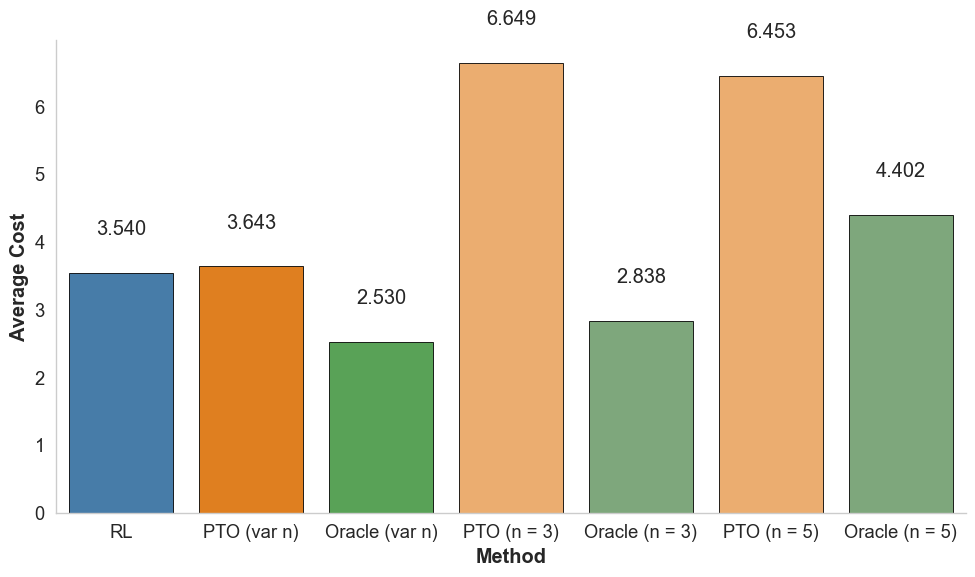

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/3592293945.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs_and_obeserved_n, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_medium_alpha_from_1.0_to_3.0_with_uniform_travel_time.png


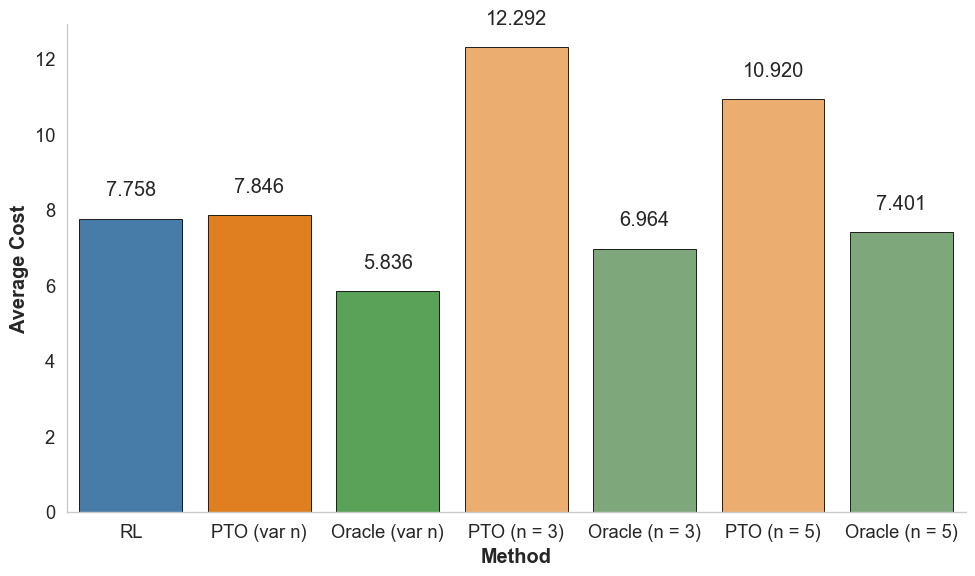

Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_high_alpha_from_3.0_to_5.0_with_uniform_travel_time.png


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/3592293945.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs_and_obeserved_n, palette=colors, edgecolor='black', linewidth=0.6)


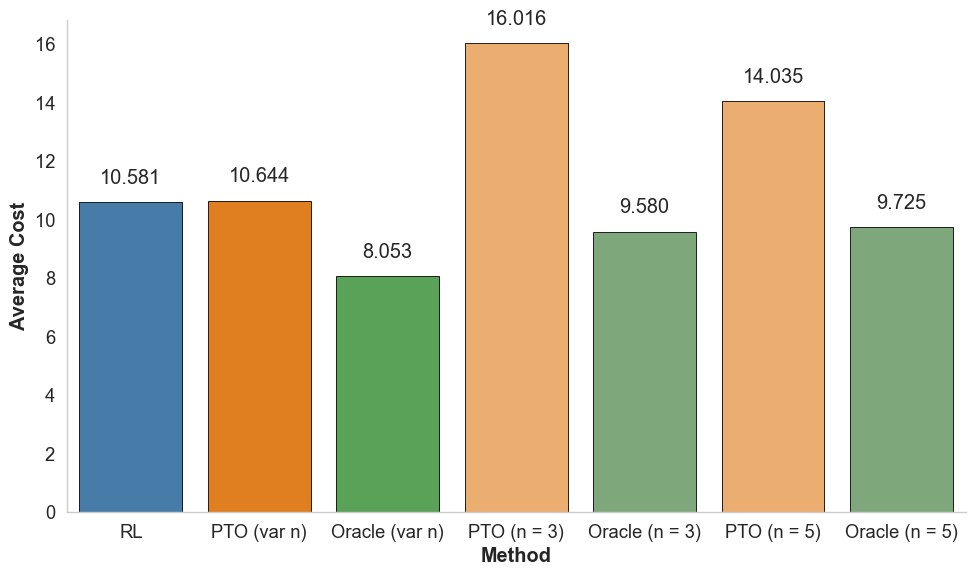

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/3592293945.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs_and_obeserved_n, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_high_beta_from_3_to_5_with_uniform_travel_time.png


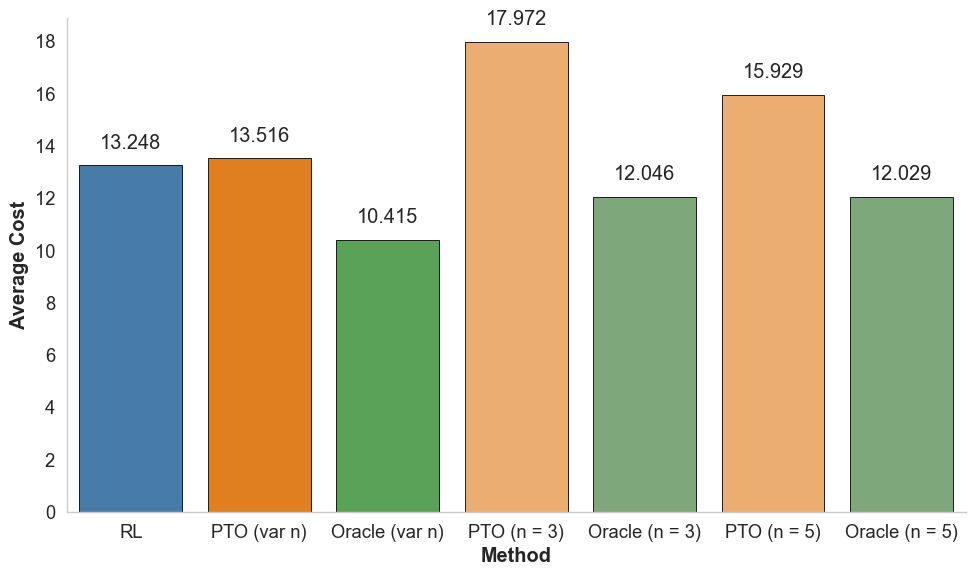

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/3592293945.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs_and_obeserved_n, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_low_alpha_from_0.1_to_1.0_with_low_travel_time.png


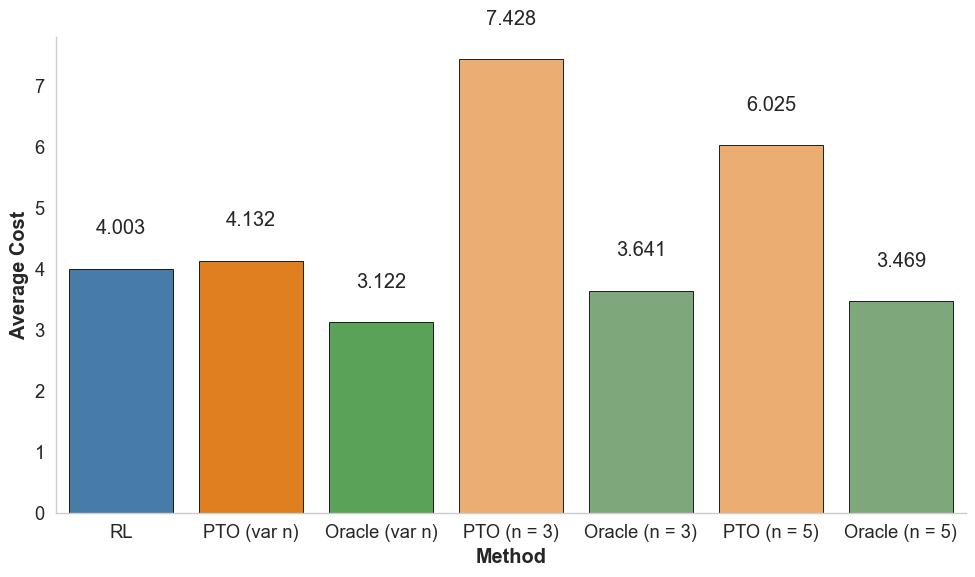

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/3592293945.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs_and_obeserved_n, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_medium_alpha_from_1.0_to_3.0_with_low_travel_time.png


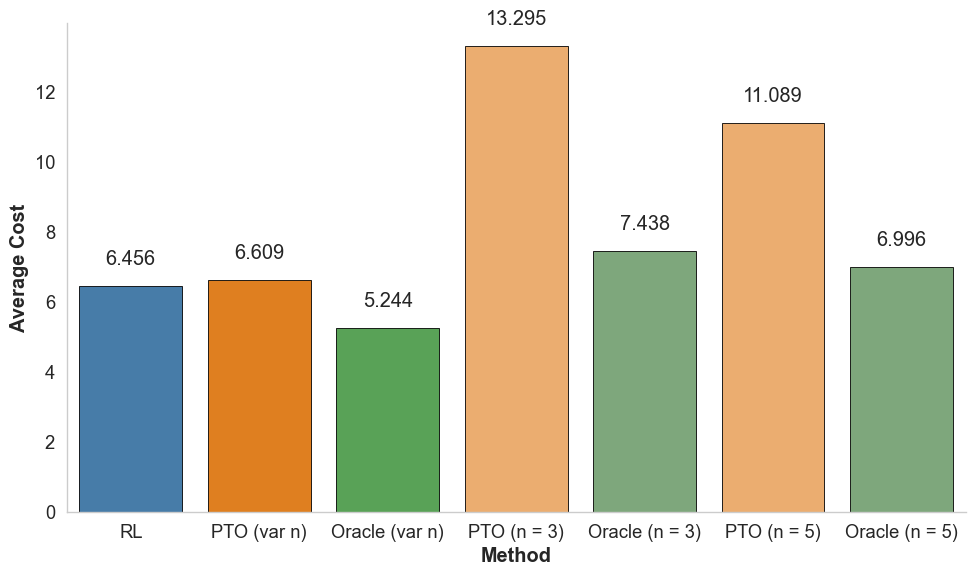

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/3592293945.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs_and_obeserved_n, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_high_alpha_from_3.0_to_5.0_with_low_travel_time.png


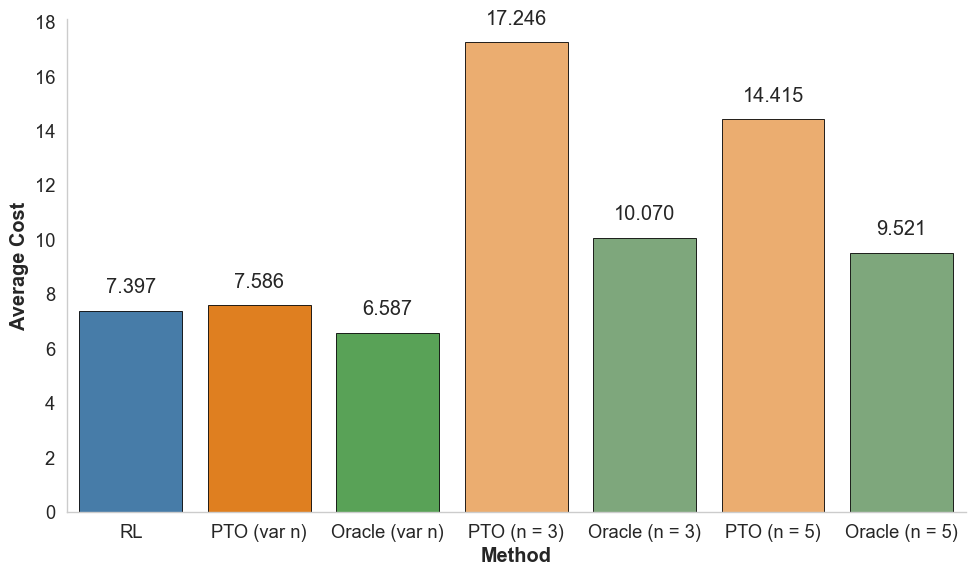

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/3592293945.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs_and_obeserved_n, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_high_beta_from_3_to_5_with_low_travel_time.png


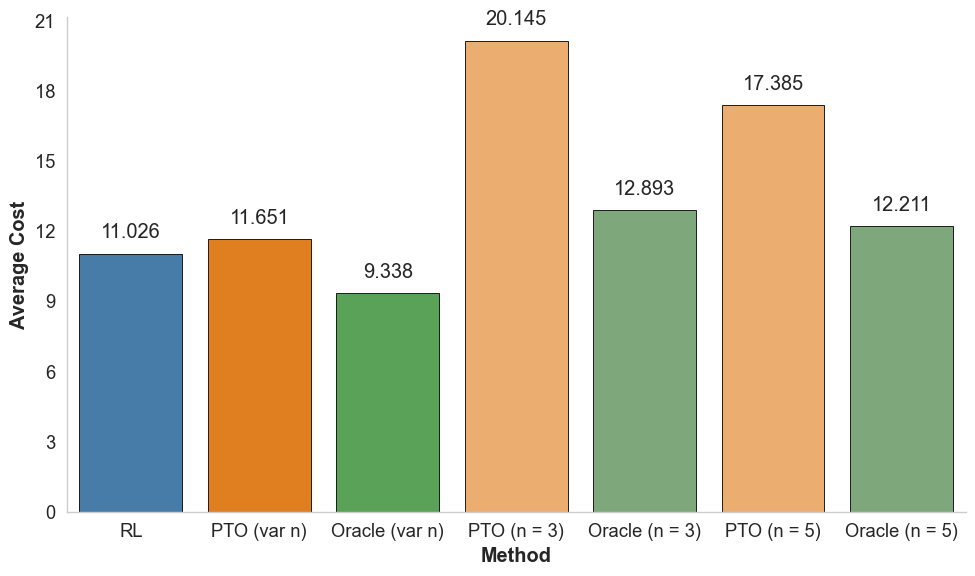

Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_low_alpha_from_0.1_to_1.0_with_high_travel_time.png


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/3592293945.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs_and_obeserved_n, palette=colors, edgecolor='black', linewidth=0.6)


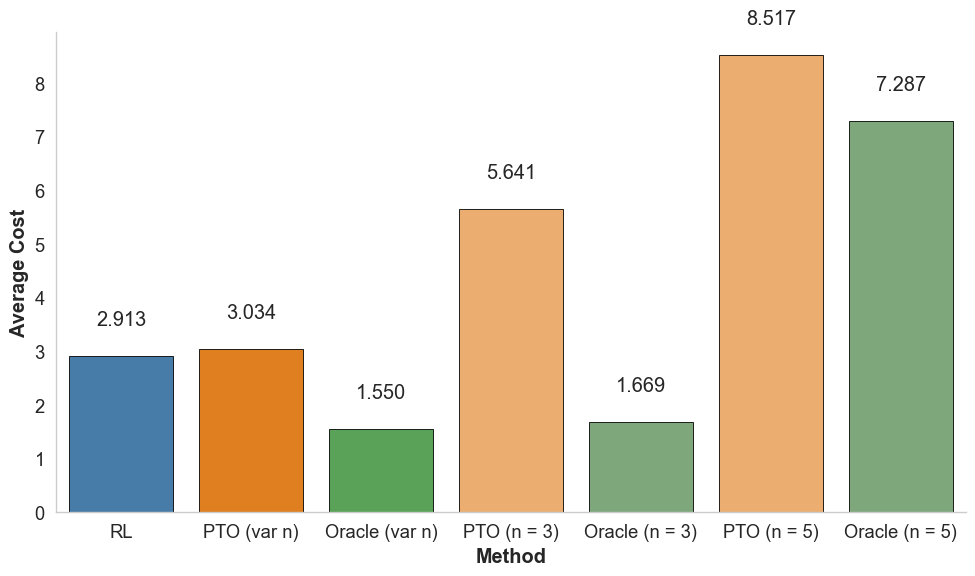

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/3592293945.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs_and_obeserved_n, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_medium_alpha_from_1.0_to_3.0_with_high_travel_time.png


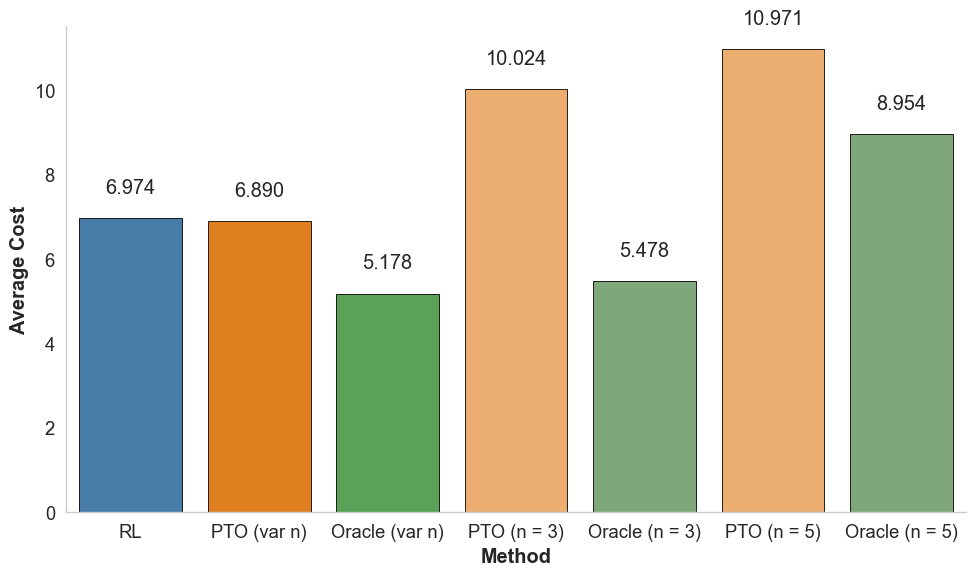

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/3592293945.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs_and_obeserved_n, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_high_alpha_from_3.0_to_5.0_with_high_travel_time.png


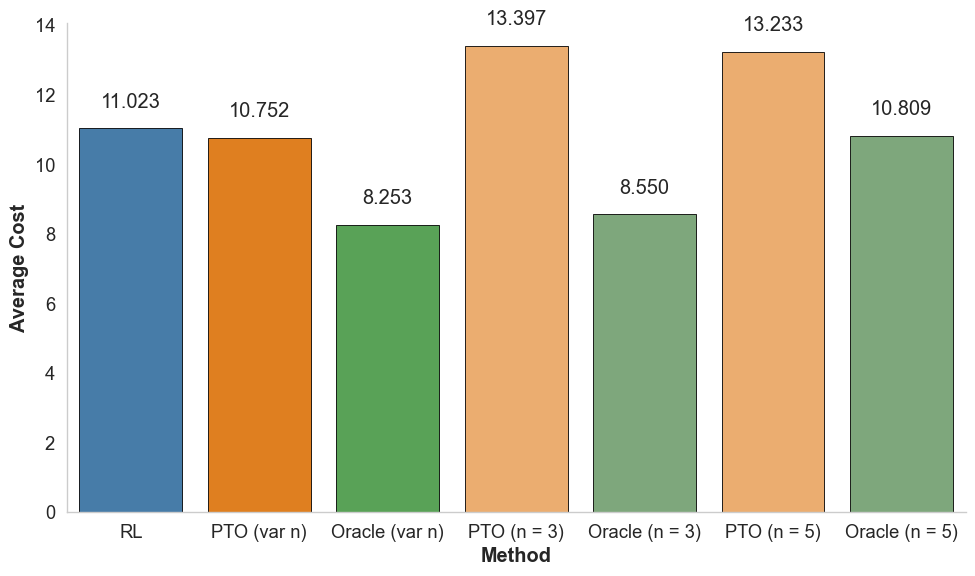

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/3592293945.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs_and_obeserved_n, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_high_beta_from_3_to_5_with_high_travel_time.png


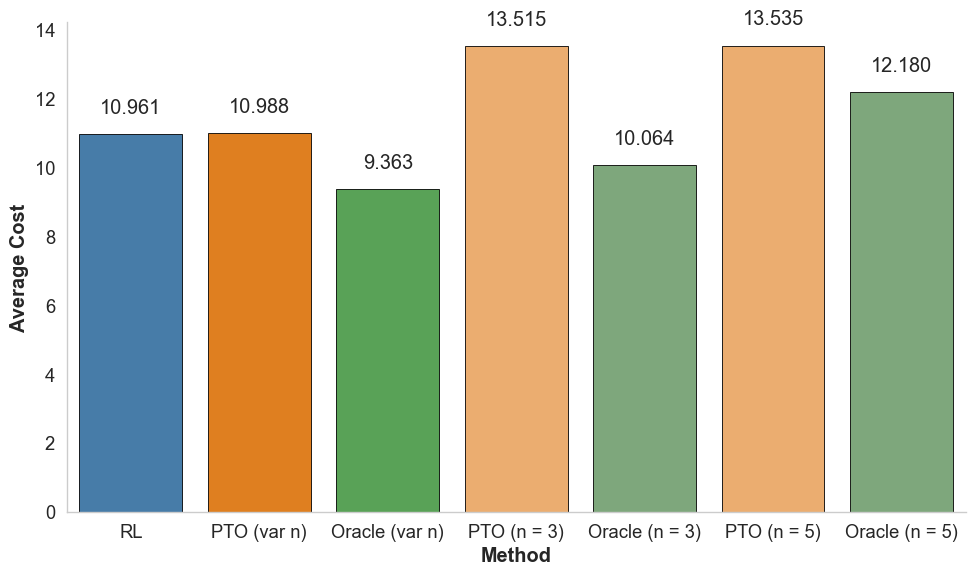

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/3592293945.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs_and_obeserved_n, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_low_alpha_from_0.1_to_1.0_with_mid_travel_time.png


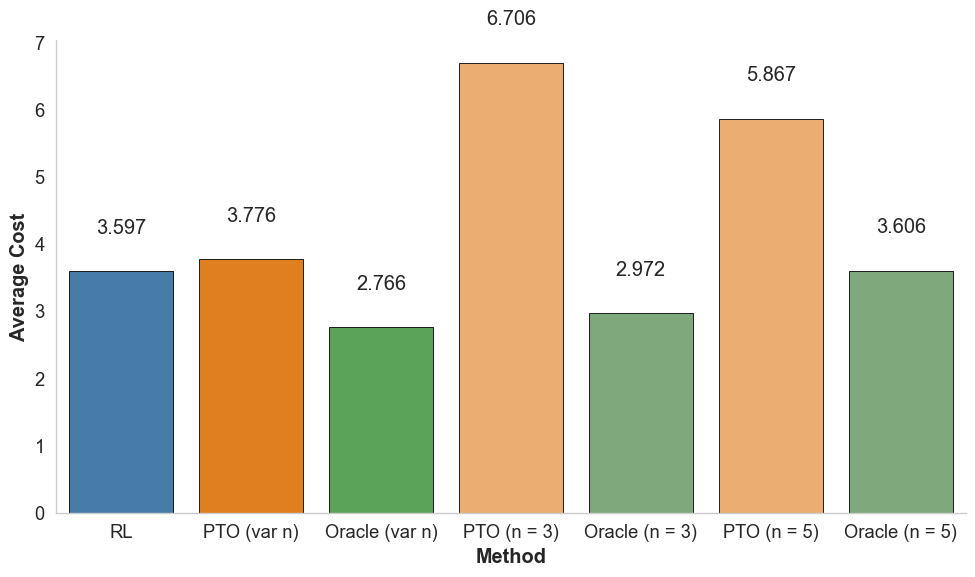

Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_medium_alpha_from_1.0_to_3.0_with_mid_travel_time.png


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/3592293945.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs_and_obeserved_n, palette=colors, edgecolor='black', linewidth=0.6)


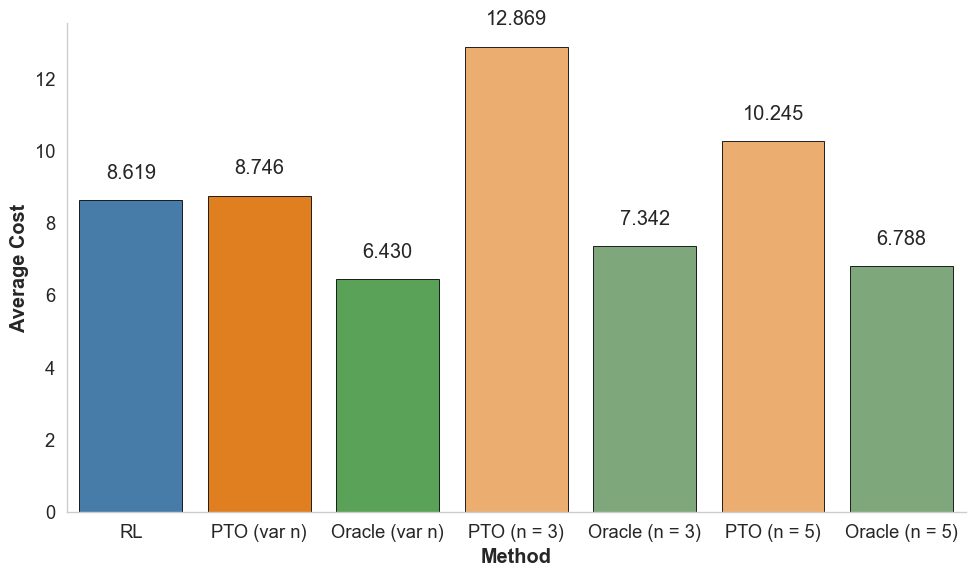

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/3592293945.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs_and_obeserved_n, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_high_alpha_from_3.0_to_5.0_with_mid_travel_time.png


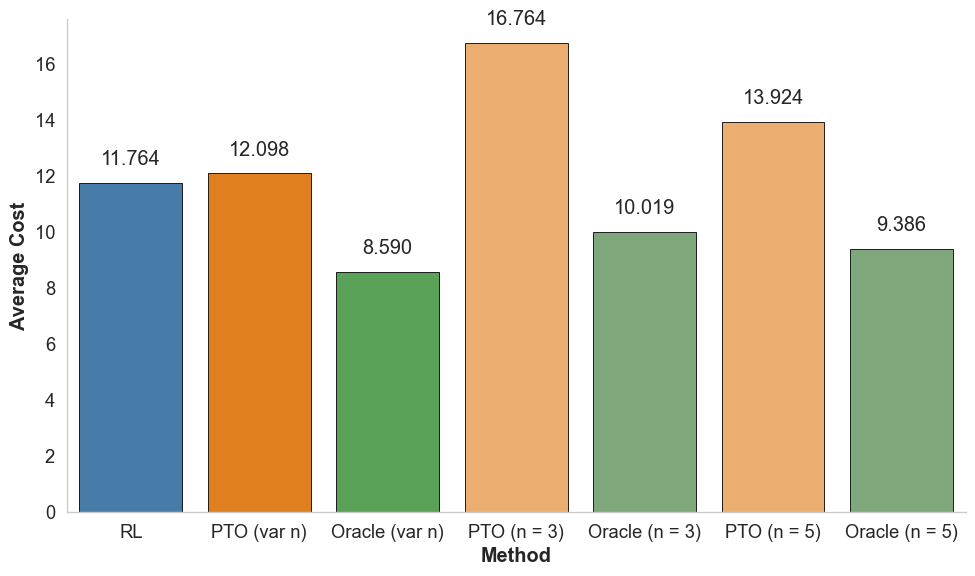

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/3592293945.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs_and_obeserved_n, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_high_beta_from_3_to_5_with_mid_travel_time.png


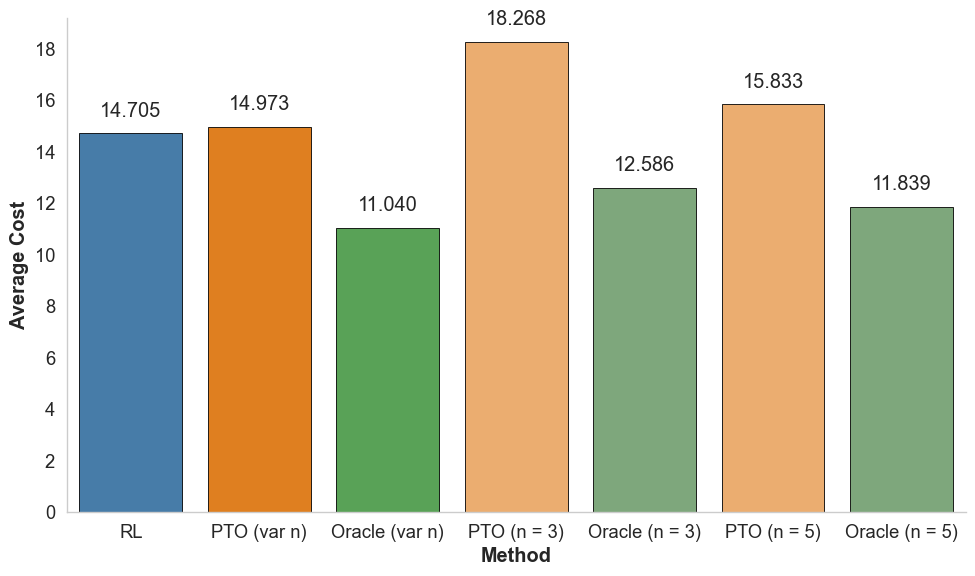

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/3592293945.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs_and_obeserved_n, palette=colors, edgecolor='black', linewidth=0.6)


Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_prof_data_test.png


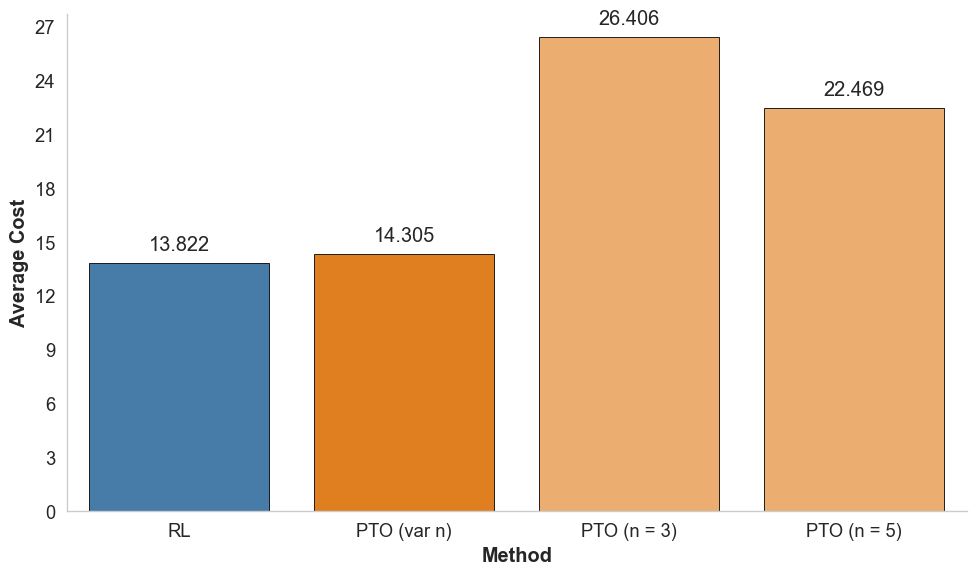

Saved figure to /Users/preetkaria/PycharmProjects/when_to_leave/figures/cost_comparison_bicycle_data_test.png


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/3592293945.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=costs_and_obeserved_n, palette=colors, edgecolor='black', linewidth=0.6)


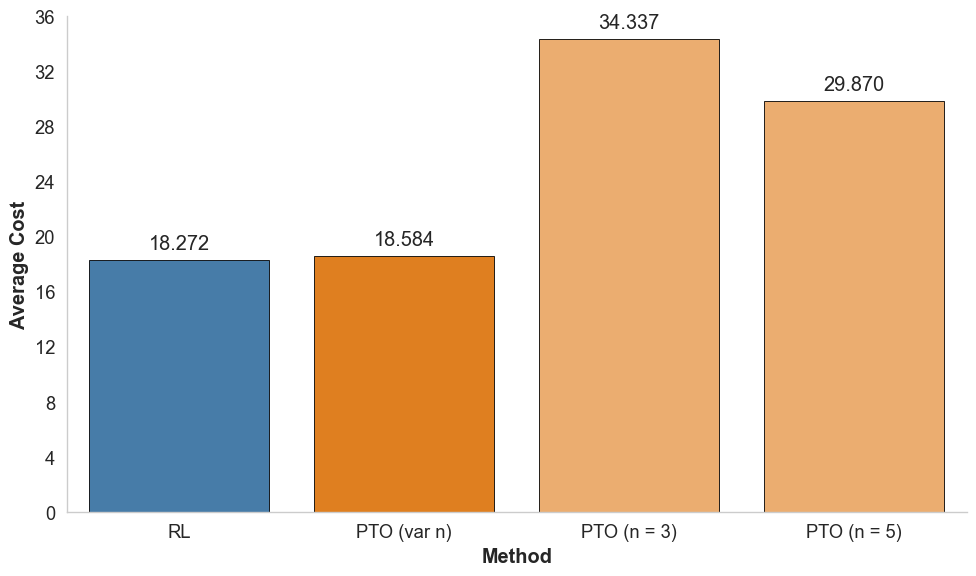

In [10]:
method_map = {'PPO': 'RL', 'PTO_Var_n': 'PTO (var n)', 'Oracle_Var_n': 'Oracle (var n)',
              'PTO_Fix_n_3': 'PTO (n = 3)', 'Oracle_Fix_n_3': 'Oracle (n = 3)',
              'PTO_Fix_n_5': 'PTO (n = 5)', 'Oracle_Fix_n_5': 'Oracle (n = 5)'}
color_map = {'PPO': '#377eb8', 'PTO_Var_n': '#ff7f00', 'Oracle_Var_n': '#4daf4a',
              'PTO_Fix_n_3': "#ffad5bff", 'Oracle_Fix_n_3': "#77ae75ff",
              'PTO_Fix_n_5': "#ffad5bff", 'Oracle_Fix_n_5': "#77ae75ff"}
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import math
from matplotlib.ticker import MaxNLocator

sns.set_theme(style='whitegrid', context='paper', font_scale=1.5, rc={"axes.labelweight": "bold"})


for row in cost_results_df.itertuples():
    
    test_name = row._1
    methods_list = list(cost_results_df.columns)[1:]
    
    if test_name == "Bicycle Data Test" or test_name == "Prof Data Test":
        methods_list = ['PPO', 'PTO_Var_n', 'PTO_Fix_n_3', 'PTO_Fix_n_5']
        
    method_list = [m for m in methods_list if not math.isnan(getattr(row, m))]
    
    costs_and_obeserved_n = [getattr(row, col) for col in methods_list]
    
    
    plt.figure(figsize=(10, 6))
    
    short_labels = [method_map[m] for m in methods_list]
    
    colors = [color_map[m] for m in methods_list]

   
    ax = sns.barplot(x=short_labels, y=costs_and_obeserved_n, palette=colors, edgecolor='black', linewidth=0.6)
    ax.set_ylabel('Average Cost')
    ax.set_xlabel('Method')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(False)
    
    sns.despine()
   
   
    for i, v in enumerate(costs_and_obeserved_n):
        ax.text(i, v + 0.5, f"{v:.3f}", ha='center', va='bottom')
    
    plt.tight_layout()
    
    config = sim_tests.get(test_name)
   
    file_name = f'cost_comparison_{test_name.replace(" ", "_").lower()}'
    plt.savefig(methods.file_path(f'{file_name}.png', dir_name='figures'))
    print(f'Saved figure to {methods.file_path(f"{file_name}.png", dir_name="figures")}')
    json.dump(config, open(methods.file_path(f'{file_name}.json', dir_name='figures'), 'w'), indent=4)
    plt.show()

## Averge Cost Compiled

,Test Name,Method,Average Cost
4,low alpha from 0.1 to 1.0 with low travel time,PPO,4.002696
5,medium alpha from 1.0 to 3.0 with low travel time,PPO,6.456435
6,high alpha from 3.0 to 5.0 with low travel time,PPO,7.397214
7,high beta from 3 to 5 with low travel time,PPO,11.026021
8,low alpha from 0.1 to 1.0 with high travel time,PPO,2.913014


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1357998363.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([


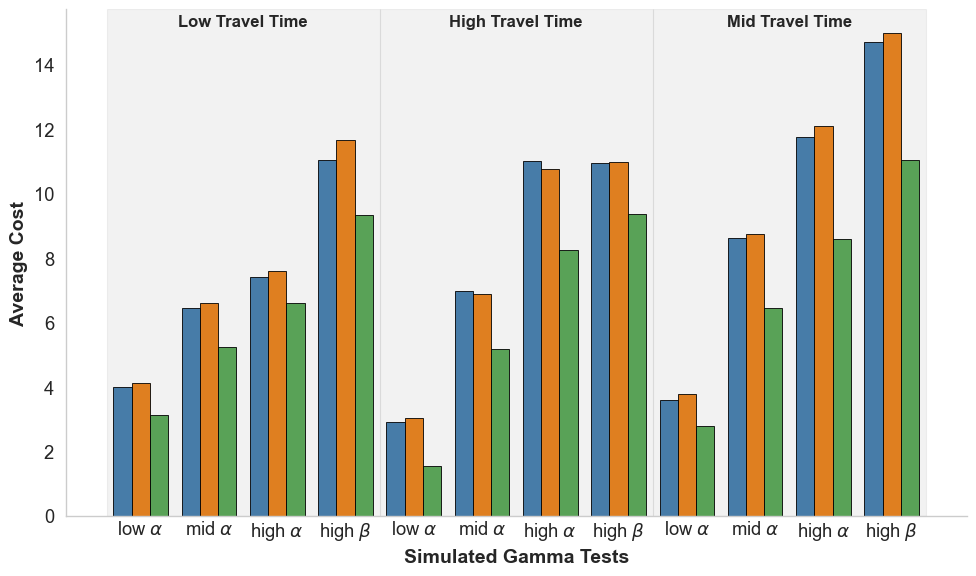

In [ ]:
# obersved n compiled plot

# Preserve 'Test Name' so it can be used on x-axis
cost_results_df_melted = cost_results_df.melt(
	id_vars='Test Name',
	var_name='Method',
	value_name='Average Cost'
)
cost_results_df_melted = cost_results_df_melted[
    cost_results_df_melted['Test Name'].str.contains('with', na=False)
    & ~cost_results_df_melted['Method'].str.contains('fix', case=False, na=False)
    & ~cost_results_df_melted['Test Name'].str.contains('uniform', na=False)
]
display(cost_results_df_melted.head())

sns.set_theme(style='whitegrid', context='paper', font_scale=1.5, rc={"axes.labelweight": "bold"})
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=cost_results_df_melted,
    x='Test Name',
    y='Average Cost',
    hue='Method',
    palette=color_map,
    edgecolor='black',
    linewidth=0.6
)
ax.set_ylabel('Average Cost', fontdict={'size': 14})
ax.set_xlabel('Simulated Gamma Tests', fontdict={'size': 14})
ax.set_xticklabels([
    r'low $\alpha$',
    r'mid $\alpha$',
    r'high $\alpha$',
    r'high $\beta$',  
] * 4)

# highlight groups: 1-4 uniform, 5-8 low, 9-12 high
group_spans = [
    (-0.5, 3.5, 'Low Travel Time'),
    (3.5, 7.5, 'High Travel Time'),
    (7.5, 11.5, 'Mid Travel Time'),
]
for xmin, xmax, label in group_spans:
    ax.axvspan(xmin, xmax, color='grey', alpha=0.1, zorder=0)
    ax.text((xmin + xmax) / 2, ax.get_ylim()[1]*0.96, label,
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.tick_params(axis='x', length=0)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.grid(False)
sns.despine()
handles, labels = ax.get_legend_handles_labels()
mapped_labels = [method_map.get(l, l) for l in labels]

# legend = ax.legend(handles, mapped_labels, title='Method')
# remove legend
_current_legend = ax.get_legend()
if _current_legend is not None:
    _current_legend.remove()

plt.tight_layout()
plt.savefig(methods.file_path('cost_comparison_compiled_low_high_mid.png', dir_name='figures'))
plt.show()

# Average Obeserved n individual Plot

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


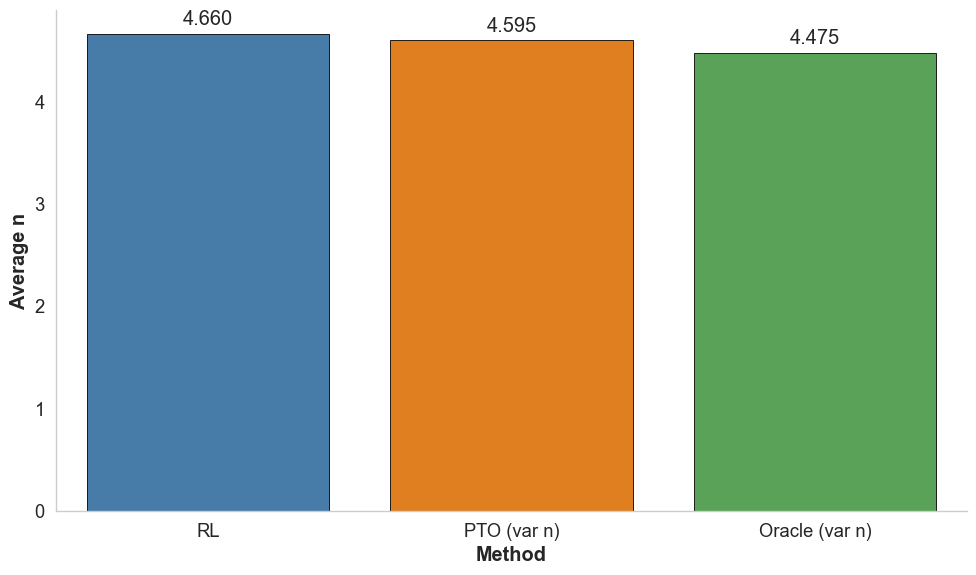

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


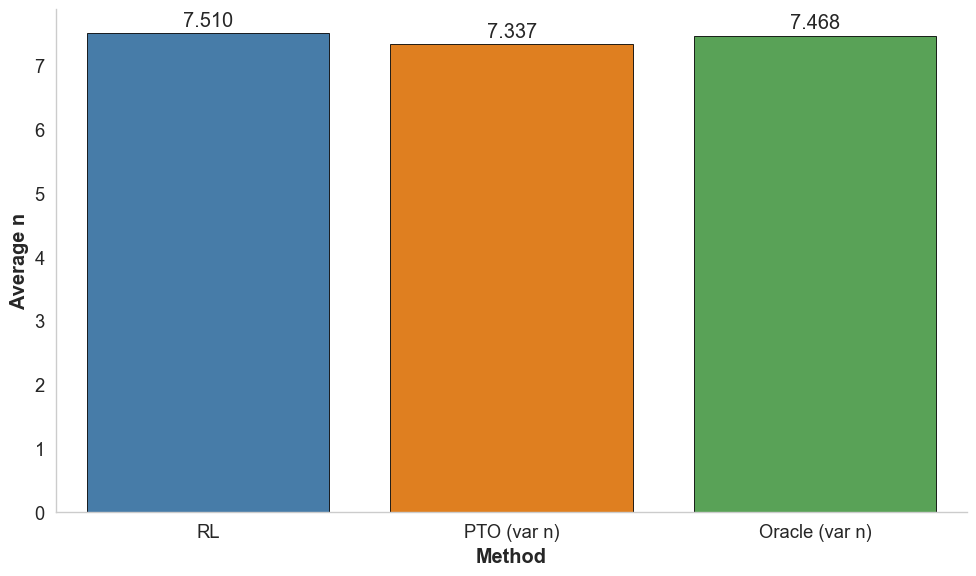

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


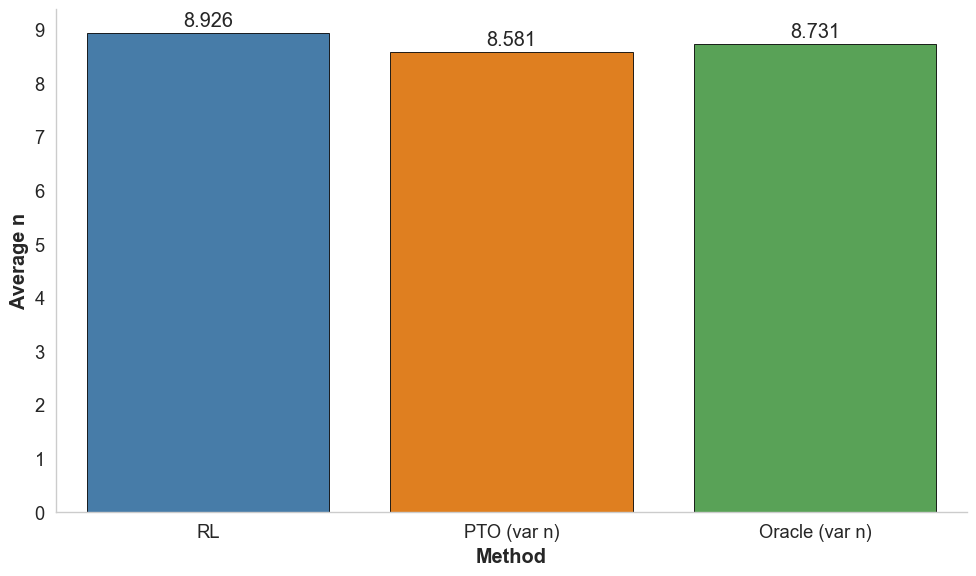

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


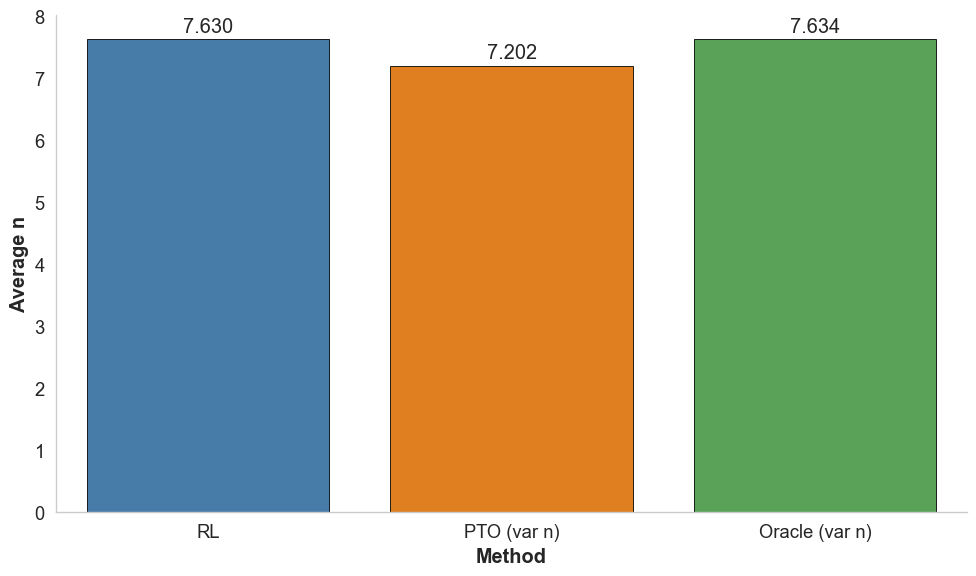

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


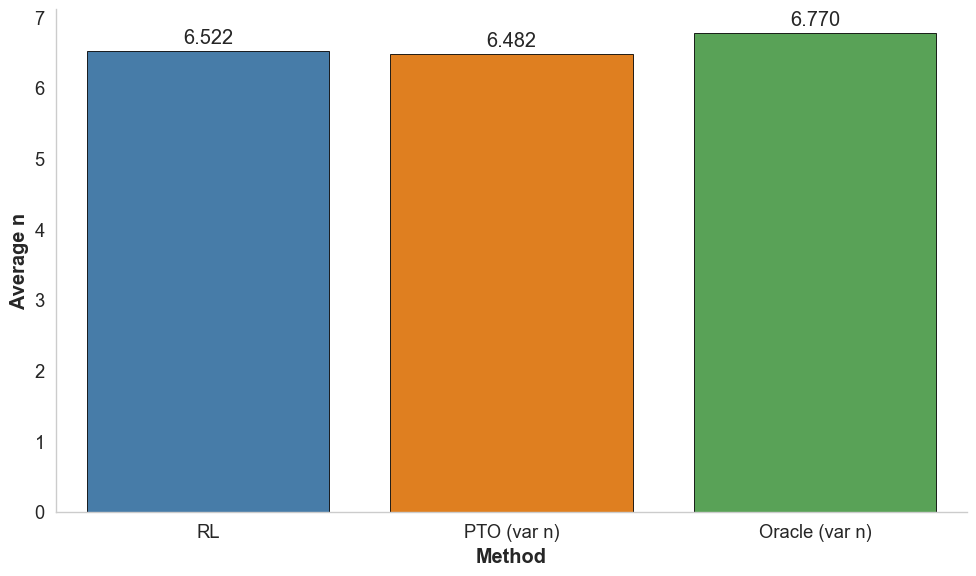

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


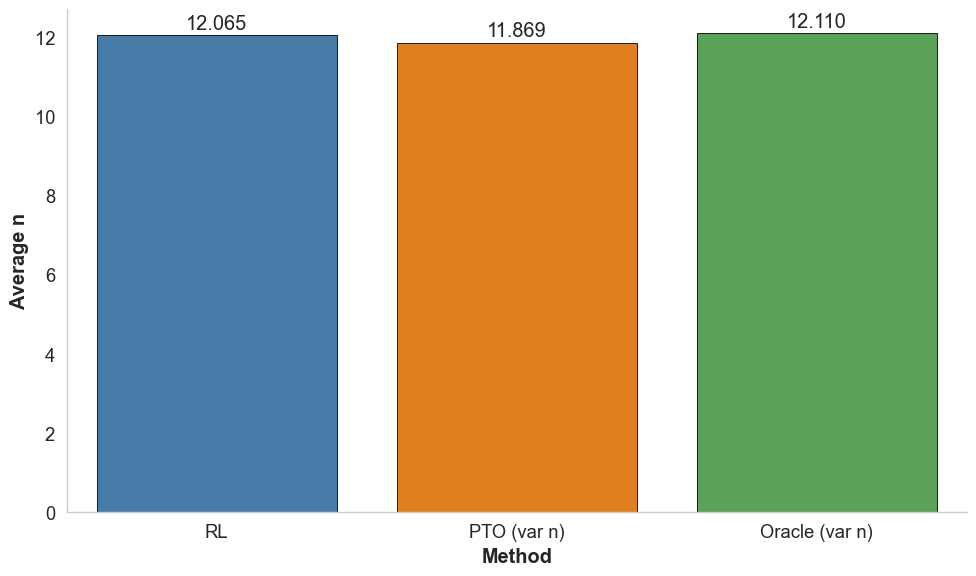

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


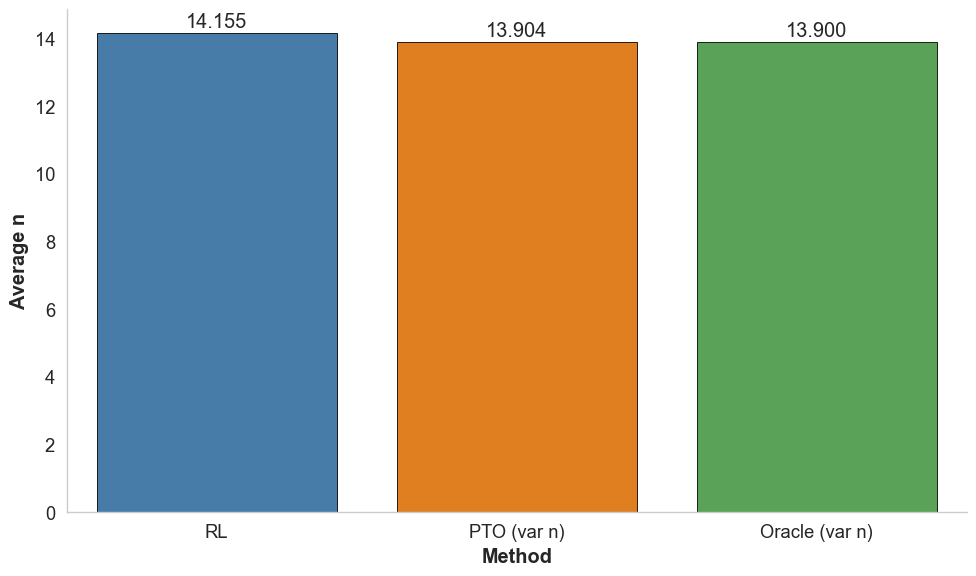

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


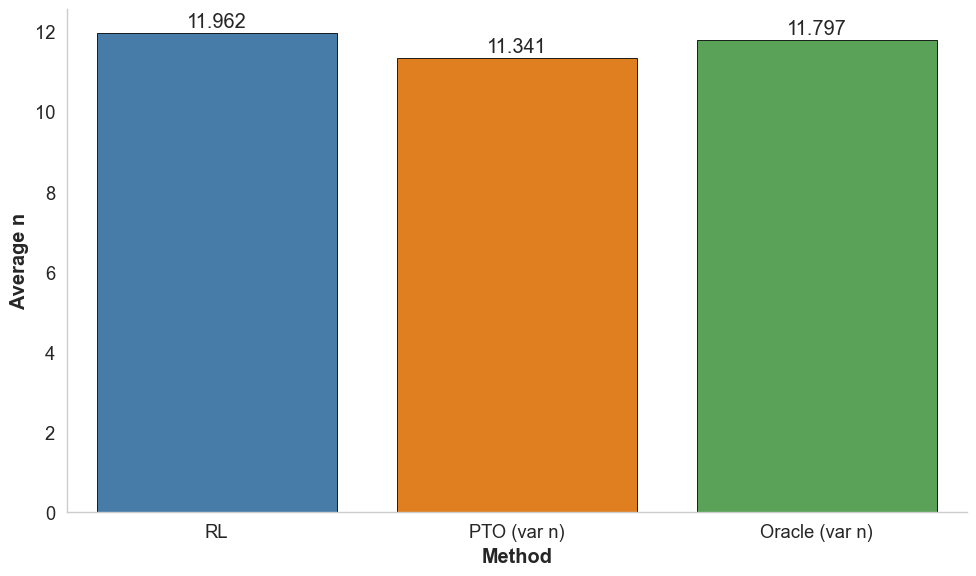

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


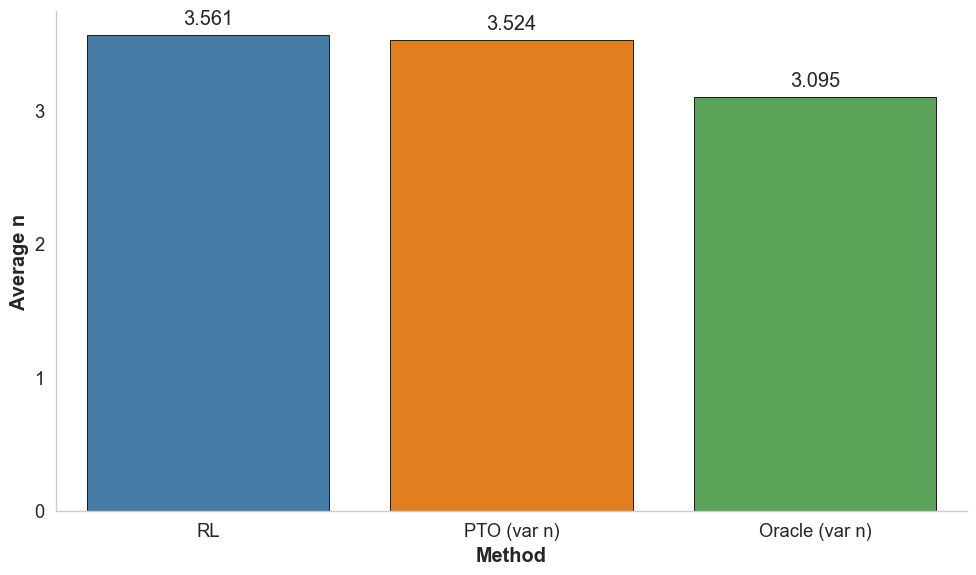

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


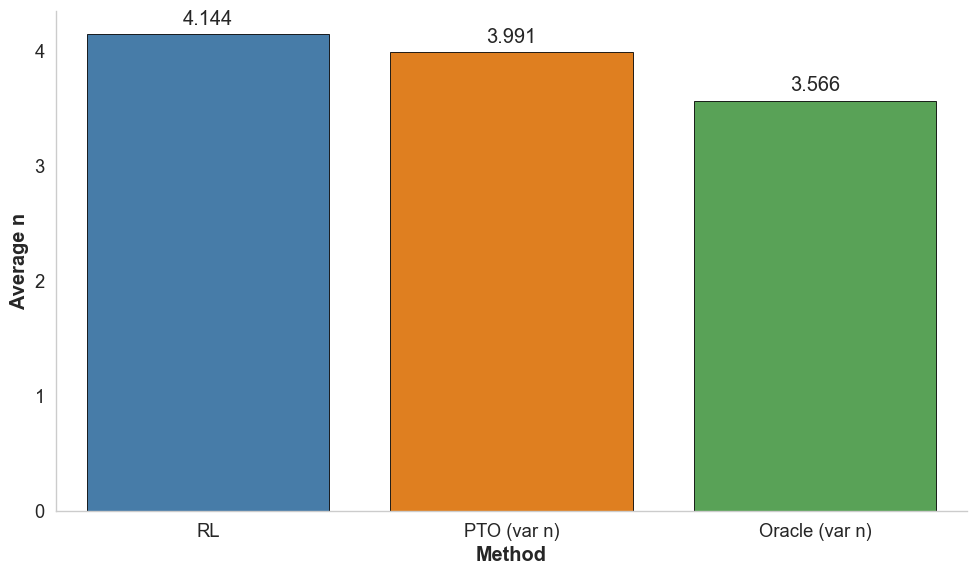

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


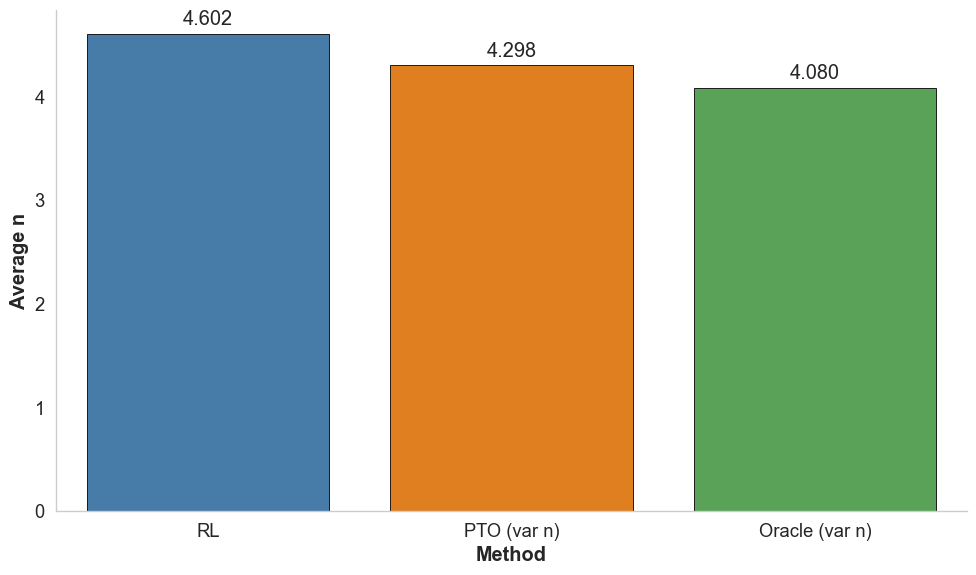

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


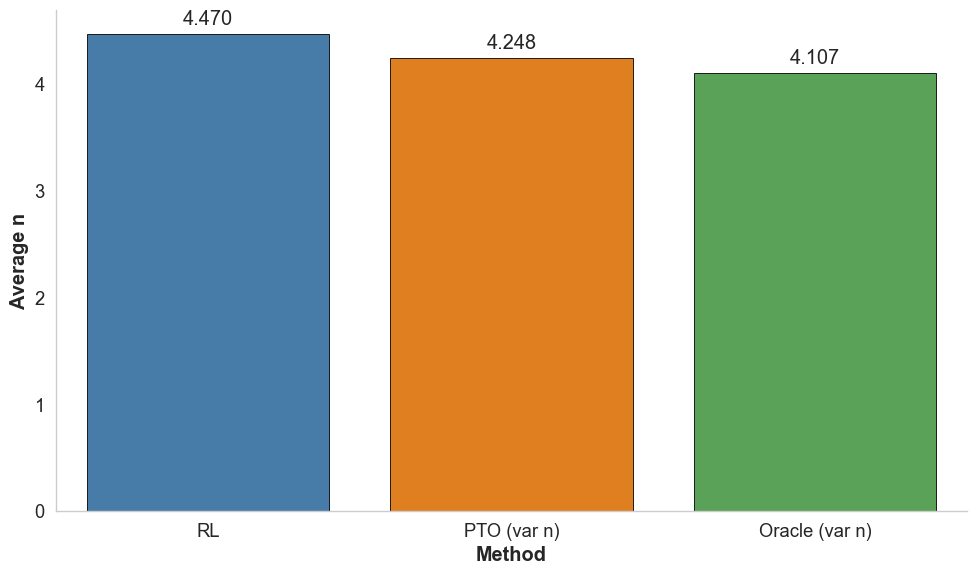

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


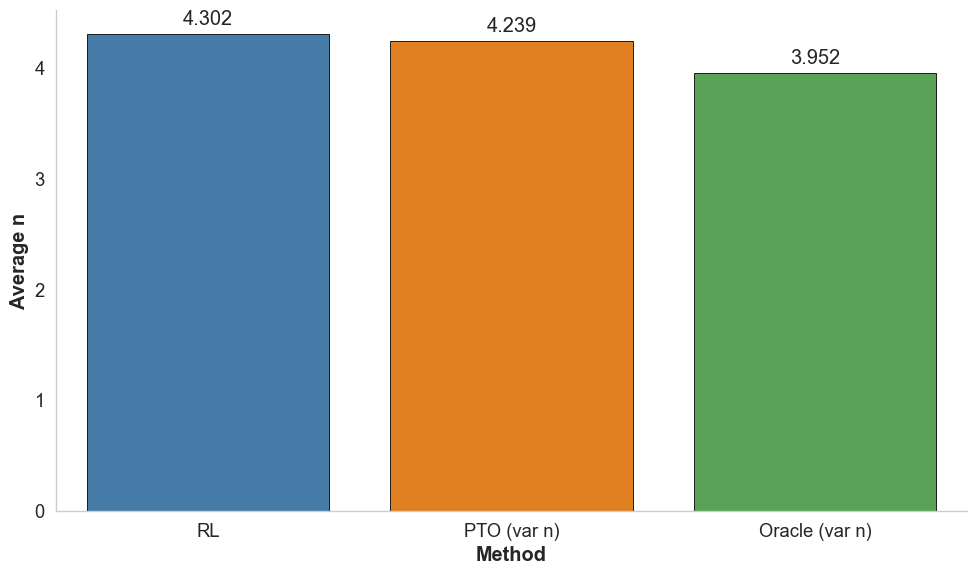

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


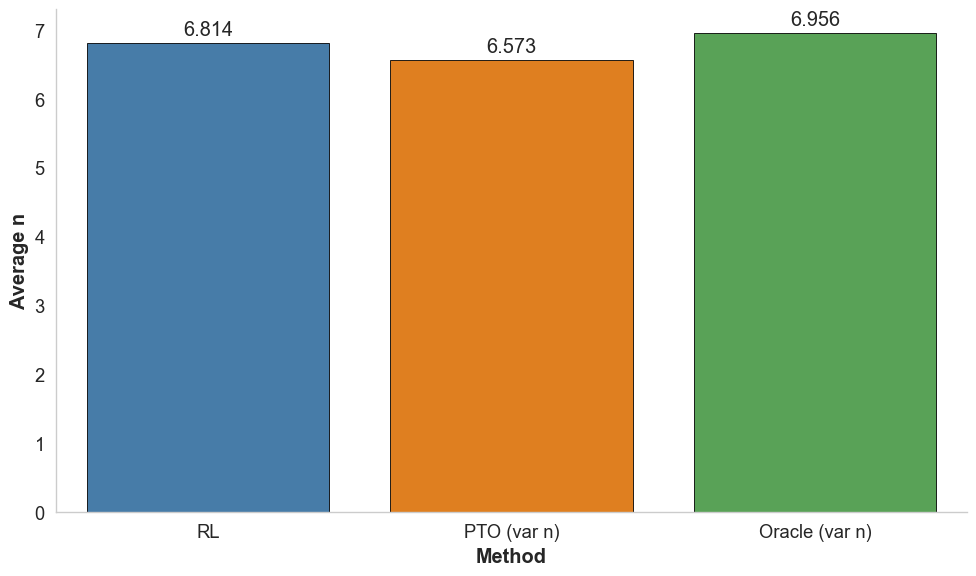

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


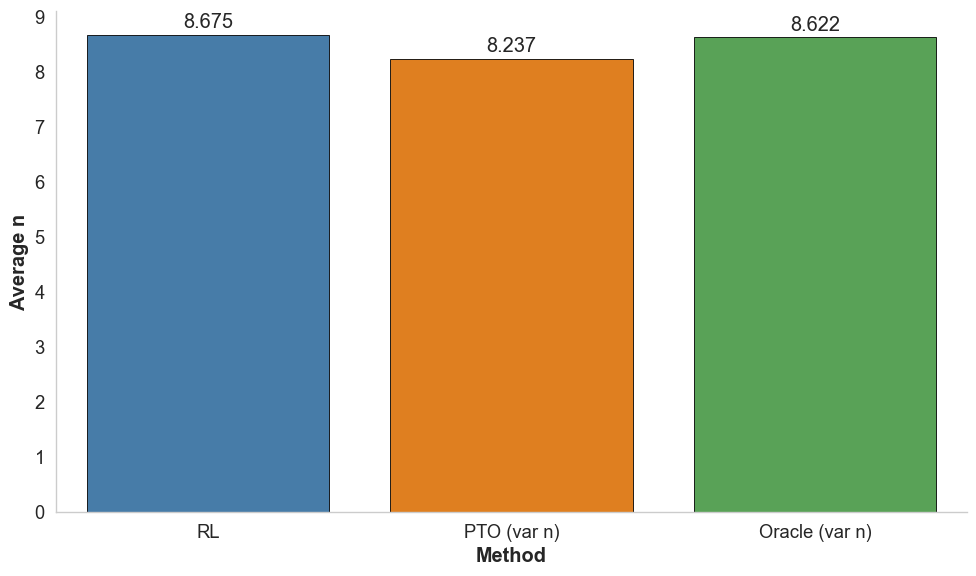

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


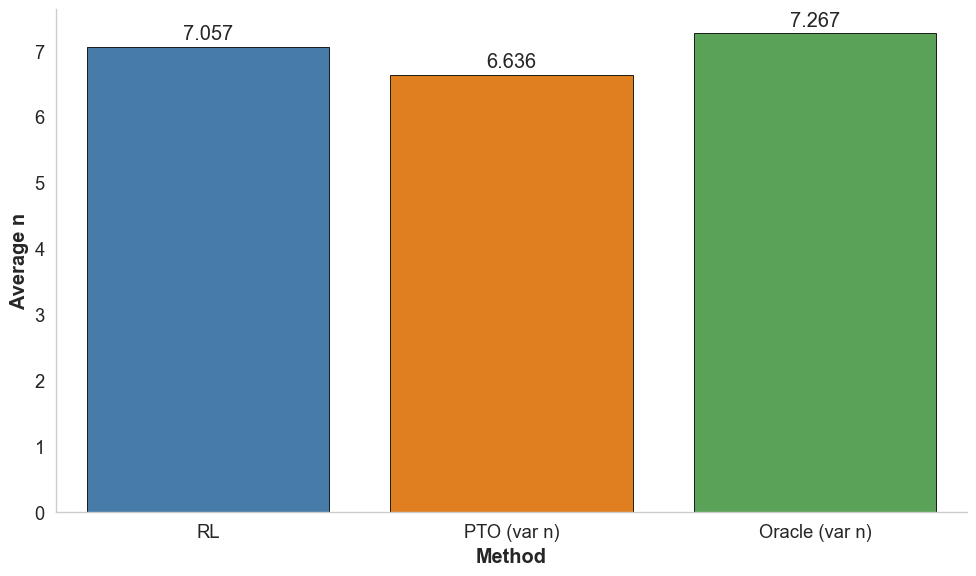

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


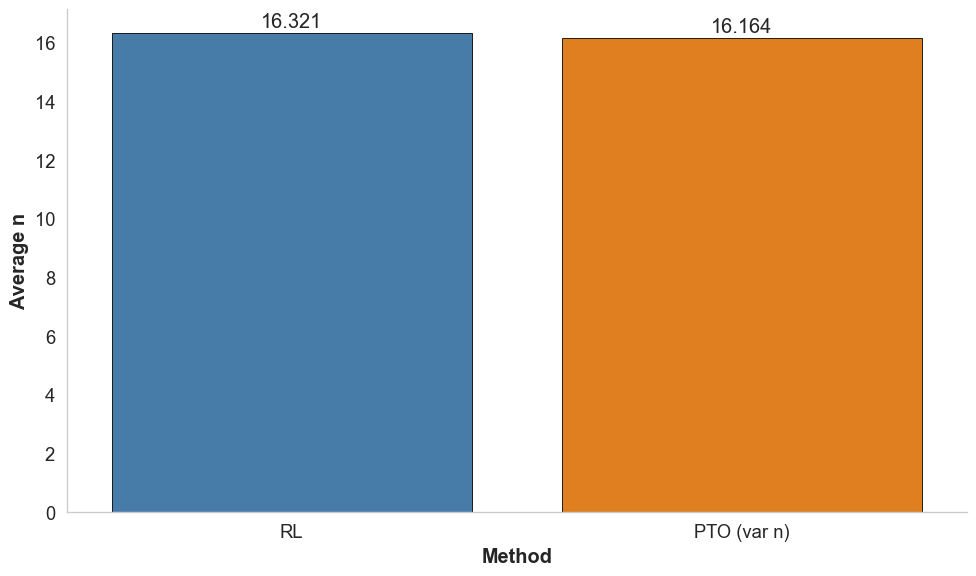

/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/1639368765.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)


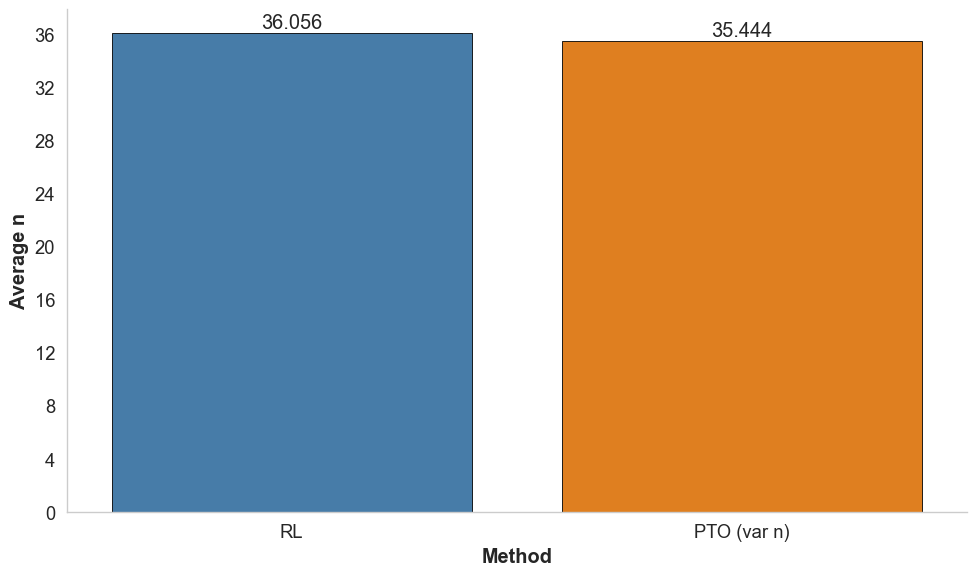

In [12]:
for row in observed_n_results_df.itertuples():
    
    test_name = row._1
    methods_list = list(observed_n_results_df.columns)[1:]
    
    if test_name == "Bicycle Data Test" or test_name == "Prof Data Test":
        methods_list = ['PPO', 'PTO_Var_n']
        
    method_list = [m for m in methods_list if not math.isnan(getattr(row, m))]
    
    observed_ns = [getattr(row, col) for col in methods_list]
    
    
    plt.figure(figsize=(10, 6))
    
    short_labels = [method_map[m] for m in methods_list]
    
    colors = [color_map[m] for m in methods_list]

   
    ax = sns.barplot(x=short_labels, y=observed_ns, palette=colors, edgecolor='black', linewidth=0.6)
    ax.set_ylabel('Average n')
    ax.set_xlabel('Method')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.grid(False)
    
    sns.despine()
   
   
    for i, v in enumerate(observed_ns):
        ax.text(i, v + 0.05, f"{v:.3f}", ha='center', va='bottom')
    
    plt.tight_layout()
    
    config = sim_tests.get(test_name)
    
    file_name = f'observed_n_comparison_{test_name.replace(" ", "_").lower()}'
    plt.savefig(methods.file_path(f'{file_name}.png', dir_name='figures'))
    json.dump(config, open(methods.file_path(f'{file_name}.json', dir_name='figures'), 'w'), indent=4)
    plt.show()

## Obeserved n Compiled plot

,Test Name,Method,Average n
0,low alpha from 0.1 to 1.0 with uniform travel ...,PPO,4.6602
1,medium alpha from 1.0 to 3.0 with uniform trav...,PPO,7.5102
2,high alpha from 3.0 to 5.0 with uniform travel...,PPO,8.9262
3,high beta from 3 to 5 with uniform travel time,PPO,7.6301
4,low alpha from 0.1 to 1.0 with low travel time,PPO,6.5216


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/2315592518.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([


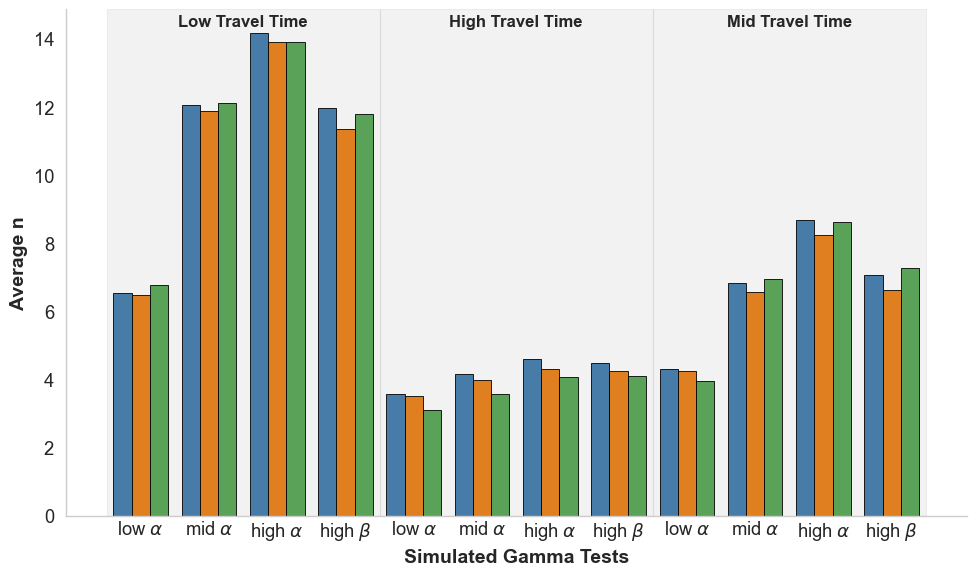

In [ ]:
# obersved n compiled plot

# Preserve 'Test Name' so it can be used on x-axis
observed_n_results_df_melted = observed_n_results_df.melt(
	id_vars='Test Name',
	var_name='Method',
	value_name='Average n'
)
display(observed_n_results_df_melted.head())
observed_n_results_df_melted = observed_n_results_df_melted[
    observed_n_results_df_melted['Test Name'].str.contains('with', na=False)
    & ~cost_results_df_melted['Test Name'].str.contains('uniform', na=False)
    ]
sns.set_theme(style='whitegrid', context='paper', font_scale=1.5, rc={"axes.labelweight": "bold"})
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=observed_n_results_df_melted,
    x='Test Name',
    y='Average n',
    hue='Method',
    palette=color_map,
    edgecolor='black',
    linewidth=0.6
)

ax.set_ylabel('Average n', fontdict={'size': 14})
ax.set_xlabel('Simulated Gamma Tests', fontdict={'size': 14})
ax.set_xticklabels([
    r'low $\alpha$',
    r'mid $\alpha$',
    r'high $\alpha$',
    r'high $\beta$',  
] * 4)

# highlight groups: 1-4 uniform, 5-8 low, 9-12 high
group_spans = [
    (-0.5, 3.5, 'Low Travel Time'),
    (3.5, 7.5, 'High Travel Time'),
    (7.5, 11.5, 'Mid Travel Time'),
]
for xmin, xmax, label in group_spans:
    ax.axvspan(xmin, xmax, color='grey', alpha=0.1, zorder=0)
    ax.text((xmin + xmax) / 2, ax.get_ylim()[1]*0.96, label,
            ha='center', va='bottom', fontsize=12, fontweight='bold')



ax.tick_params(axis='x', length=0)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.grid(False)
sns.despine()
handles, labels = ax.get_legend_handles_labels()
mapped_labels = [method_map.get(l, l) for l in labels]

# legend = ax.legend(handles, mapped_labels, title='Method')
# remove legend
_current_legend = ax.get_legend()
if _current_legend is not None:
    _current_legend.remove()

plt.tight_layout()

plt.savefig(methods.file_path('observed_n_comparison_compiled_low_high_mid.png', dir_name='figures'))
plt.show()



## Late Fraction Compiled Plot

,Test Name,Method,Late Fraction
0,low alpha from 0.1 to 1.0 with uniform travel ...,PPO,0.0477
1,medium alpha from 1.0 to 3.0 with uniform trav...,PPO,0.1019
2,high alpha from 3.0 to 5.0 with uniform travel...,PPO,0.1442
3,high beta from 3 to 5 with uniform travel time,PPO,0.1540
4,low alpha from 0.1 to 1.0 with low travel time,PPO,0.0309


/var/folders/6b/tmvvscrj5wb5r4ngnndf1gtm0000gn/T/ipykernel_5269/4096302736.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([


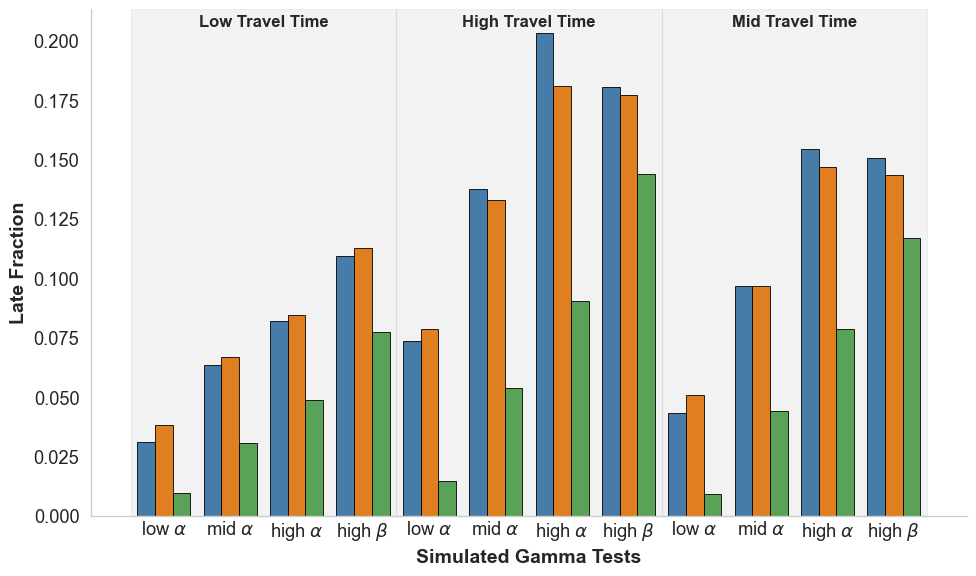

In [ ]:
# obersved n compiled plot

# Preserve 'Test Name' so it can be used on x-axis
late_fraction_df_melted = late_fraction_df.melt(
	id_vars='Test Name',
	var_name='Method',
	value_name='Late Fraction'
)
display(late_fraction_df_melted.head())

late_fraction_df_melted = late_fraction_df_melted[
    late_fraction_df_melted['Test Name'].str.contains('with', na=False)
    & ~late_fraction_df_melted['Method'].str.contains('fix', case=False, na=False)
    & ~cost_results_df_melted['Test Name'].str.contains('uniform', na=False)
]

sns.set_theme(style='whitegrid', context='paper', font_scale=1.5, rc={"axes.labelweight": "bold"})
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=late_fraction_df_melted,
    x='Test Name',
    y='Late Fraction',
    hue='Method',
    palette=color_map,
    edgecolor='black',
    linewidth=0.6
)

ax.set_ylabel('Late Fraction', fontdict={'size': 14})
ax.set_xlabel('Simulated Gamma Tests', fontdict={'size': 14})
ax.set_xticklabels([
    r'low $\alpha$',
    r'mid $\alpha$',
    r'high $\alpha$',
    r'high $\beta$',  
] * 4)

# highlight groups: 1-4 uniform, 5-8 low, 9-12 high, 13-16 medium
group_spans = [
    (-0.5, 3.5, 'Low Travel Time'),
    (3.5, 7.5, 'High Travel Time'),
    (7.5, 11.5, 'Mid Travel Time'),
]

for xmin, xmax, label in group_spans:
    ax.axvspan(xmin, xmax, color='grey', alpha=0.1, zorder=0)
    ax.text((xmin + xmax) / 2, ax.get_ylim()[1]*0.96, label,
            ha='center', va='bottom', fontsize=12, fontweight='bold')




ax.tick_params(axis='x', length=0)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax.grid(False)
sns.despine()
handles, labels = ax.get_legend_handles_labels()
mapped_labels = [method_map.get(l, l) for l in labels]

# legend = ax.legend(handles, mapped_labels, title='Method')
# remove legend
_current_legend = ax.get_legend()
if _current_legend is not None:
    _current_legend.remove()

plt.tight_layout()

plt.savefig(methods.file_path('late_fraction_ratio_comparison_low_high_mid.png', dir_name='figures'))
plt.show()


## u* Comparision with alpha and beta

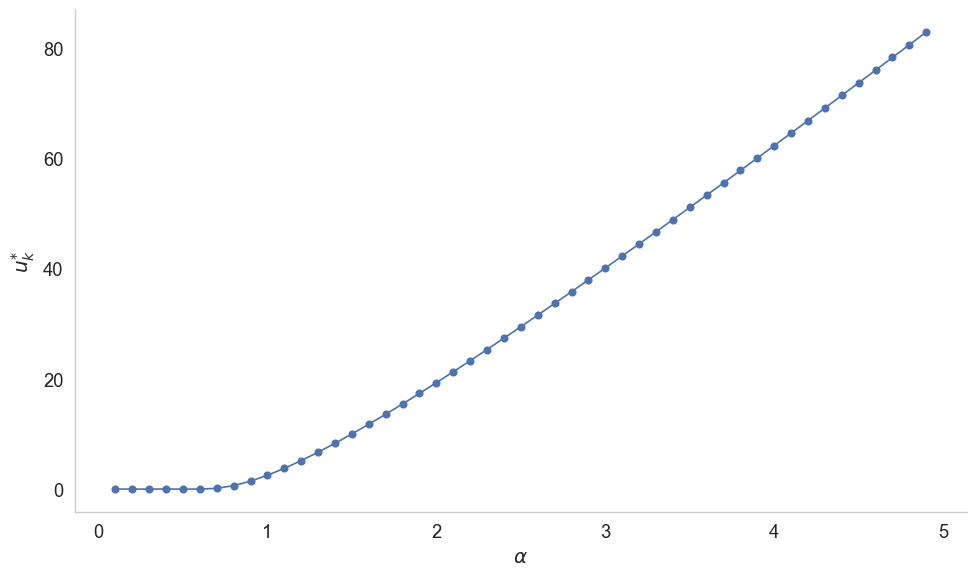

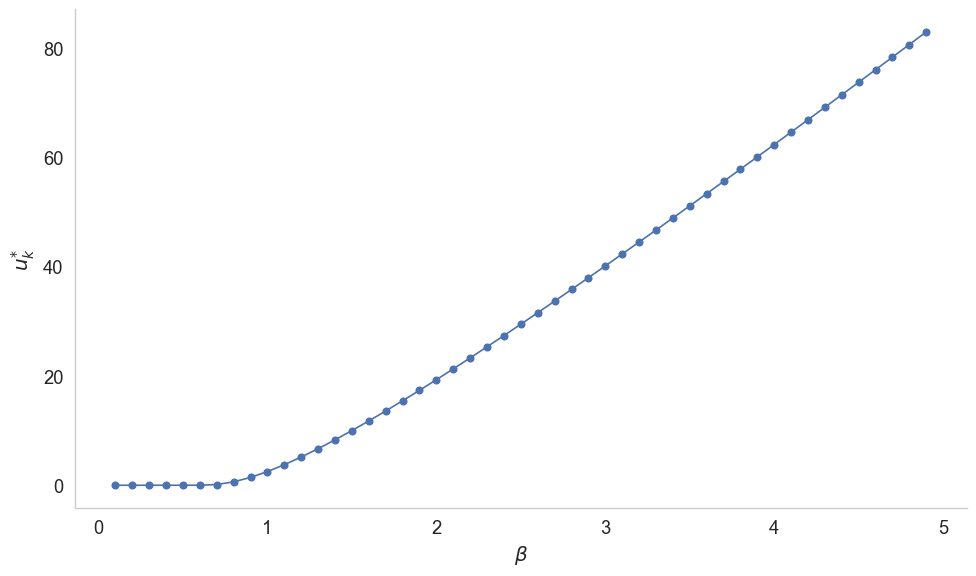

In [15]:
# u* vs alpha plot
config = {
    'k': 10,
    'alpha_range': np.arange(0.1, 5, 0.1).tolist(),
    'beta': 2,
    'h': 0.5,
    'c': 25,
}
u_values = [methods.get_u_star_binary_fast(alpha, config['beta'], config['k'], config['h'], config['c']) for alpha in config['alpha_range']]

# plot u* vs alpha
plt.figure(figsize=(10, 6))
plt.plot(config['alpha_range'], u_values, marker='o')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$u_k^{*}$")
plt.grid()
plt.tight_layout()
sns.despine()
file_name = 'u_star_vs_alpha'
json.dump(config, open(methods.file_path(f'{file_name}.json', dir_name='figures'), 'w'), indent=4)
plt.savefig(methods.file_path('u_star_vs_alpha.png', dir_name='figures'))
plt.show()


# u* vs beta plot
config = {
    'k': 10,
    'alpha': 2,
    'beta_range': np.arange(0.1, 5, 0.1).tolist(),
    'h': 0.5,
    'c': 25,
}
u_values = [methods.get_u_star_binary_fast(config['alpha'], beta, config['k'], config['h'], config['c']) for beta in config['beta_range']]
# plot u* vs beta
plt.figure(figsize=(10, 6))
plt.plot(config['beta_range'], u_values, marker='o')
plt.xlabel(r"$\beta$")
plt.ylabel(r"$u_k^{*}$")
plt.grid()
plt.tight_layout()
sns.despine()
file_name = 'u_star_vs_beta'
json.dump(config, open(methods.file_path(f'{file_name}.json', dir_name='figures'), 'w'), indent=4)
plt.savefig(methods.file_path('u_star_vs_beta.png', dir_name='figures'))
plt.show()


## Plot travel time distributions

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/9f469_10K.pkl



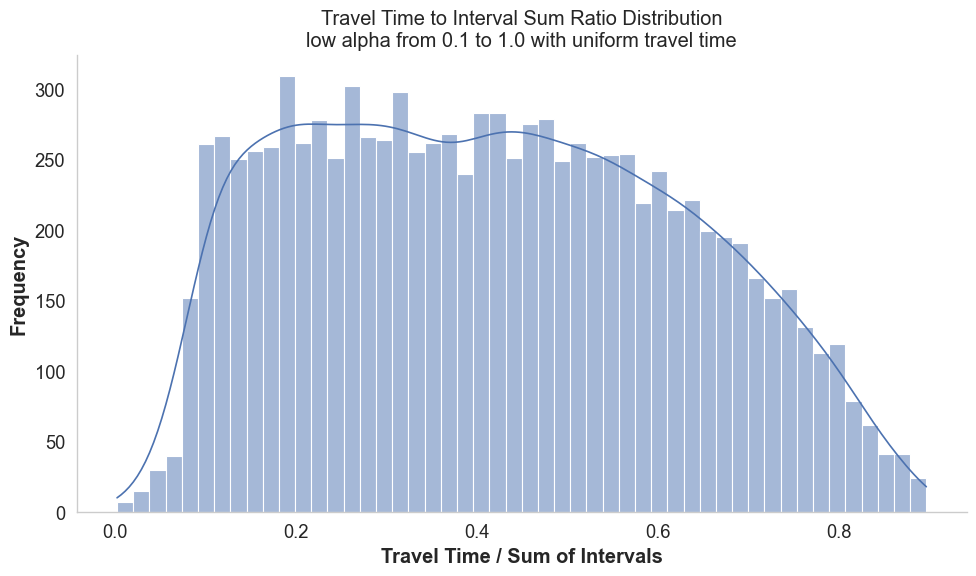

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/8b77a_10K.pkl



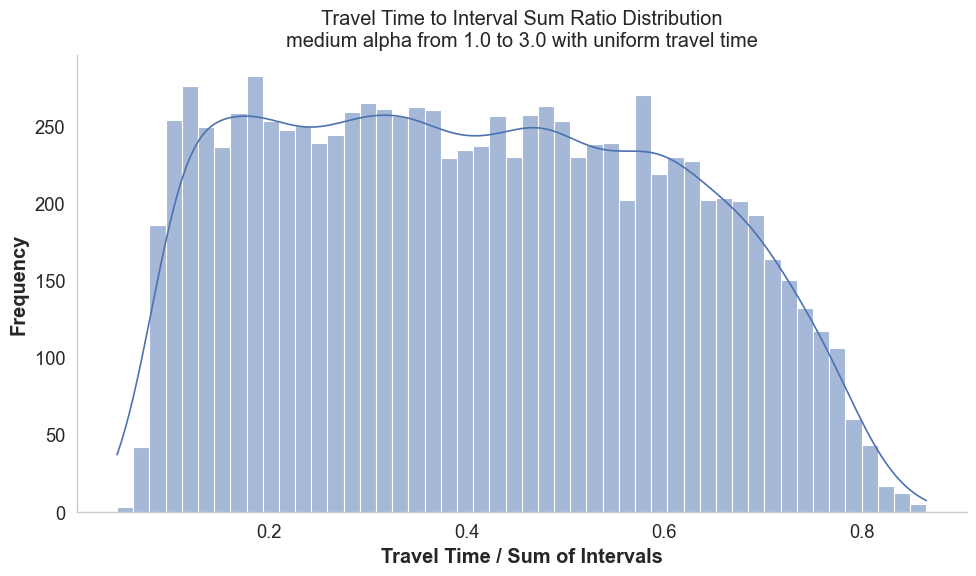

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/ffd47_10K.pkl



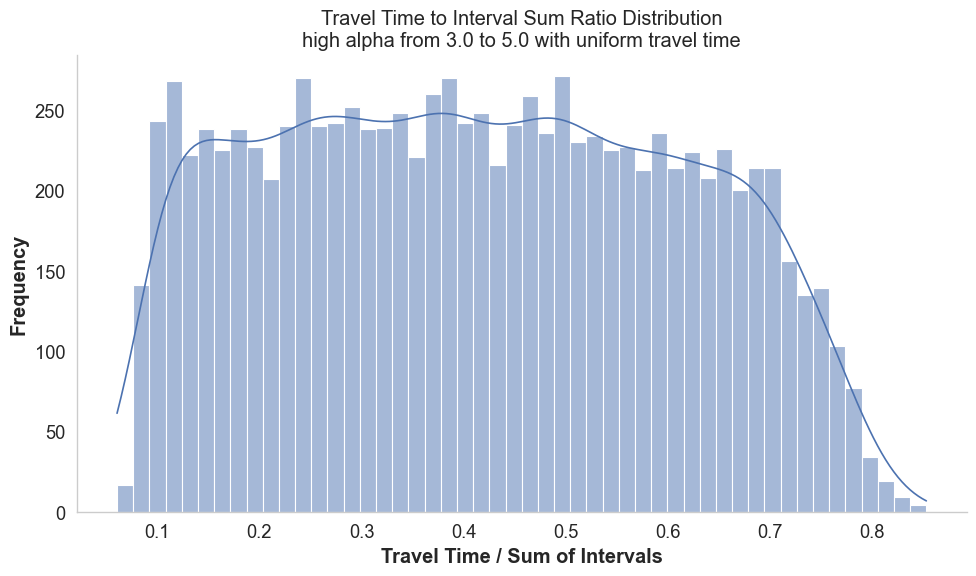

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/c77a2_10K.pkl



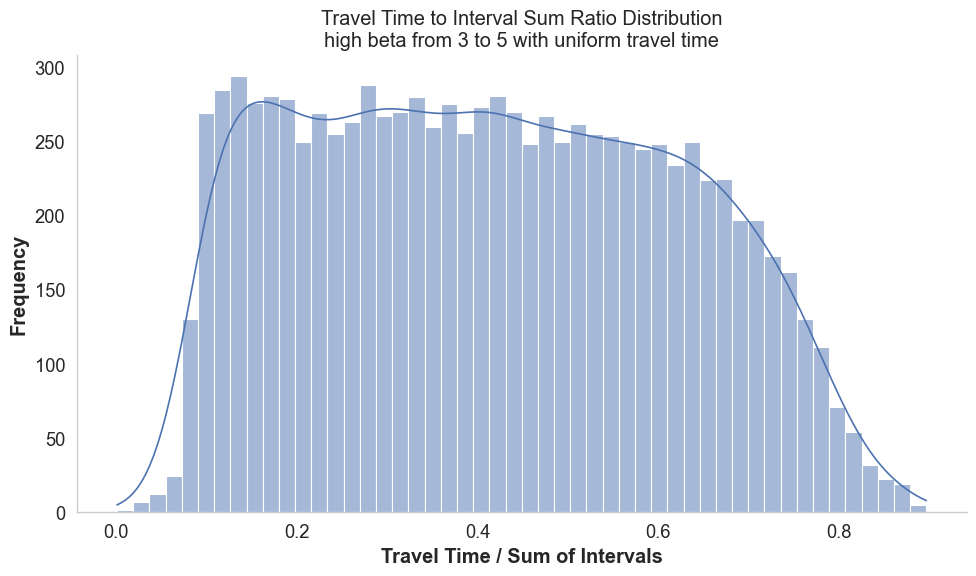

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/81641_10K.pkl



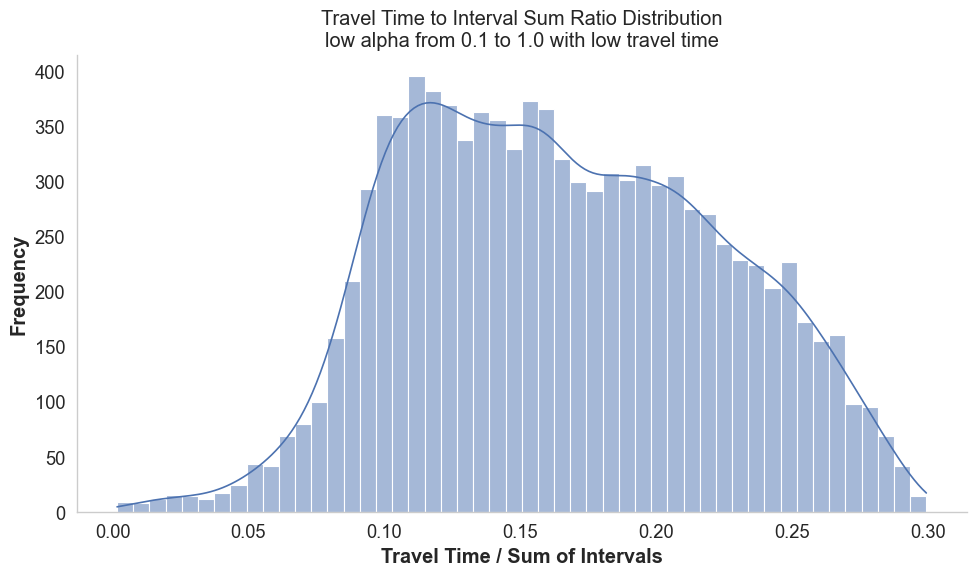

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/0c4e9_10K.pkl



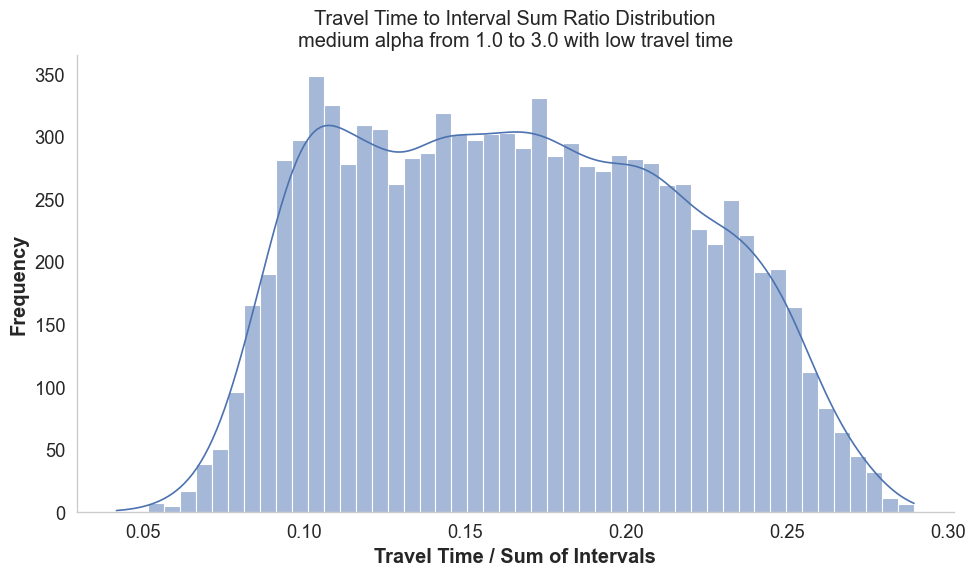

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/ad796_10K.pkl



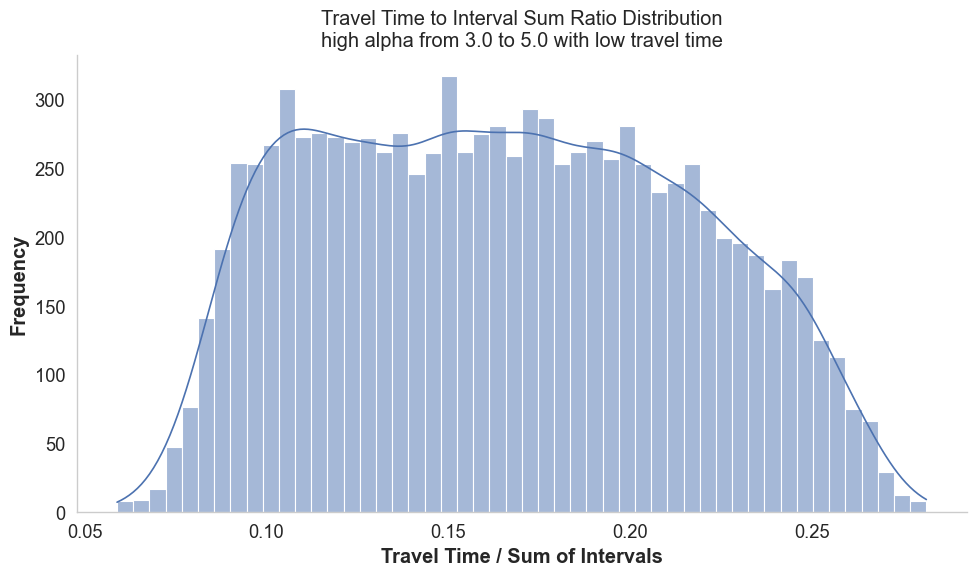

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/e425c_10K.pkl



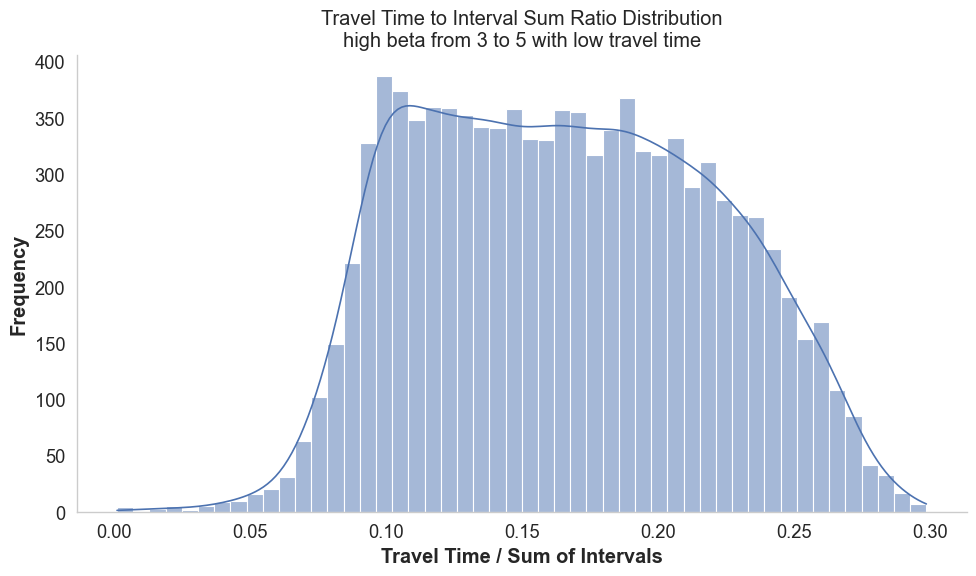

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/0b349_10K.pkl



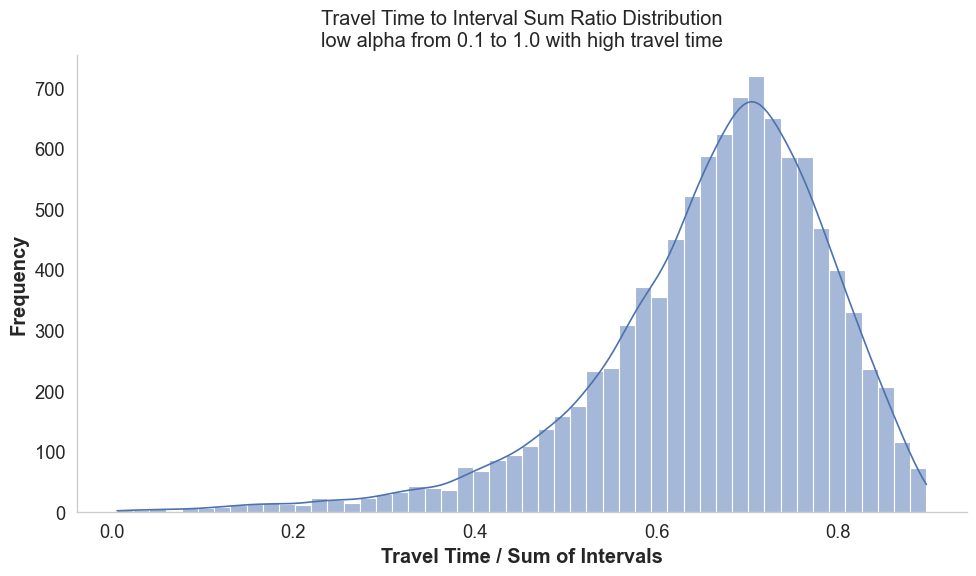

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/f2aec_10K.pkl



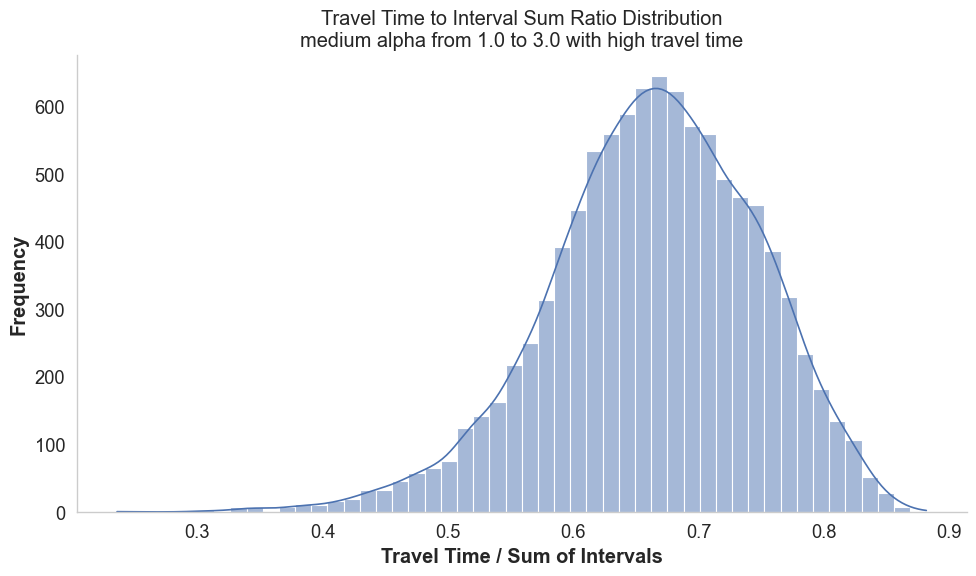

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/4556d_10K.pkl



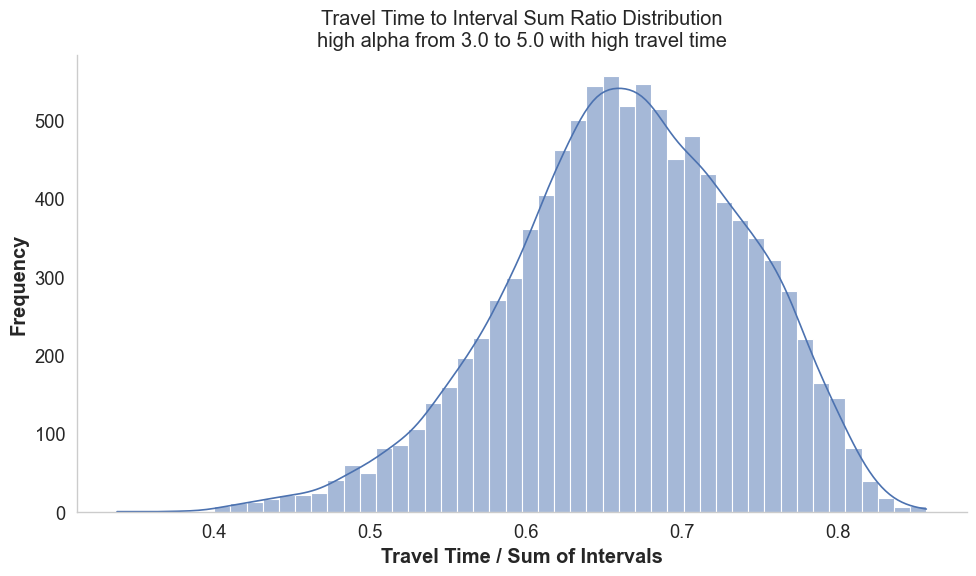

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/319b8_10K.pkl



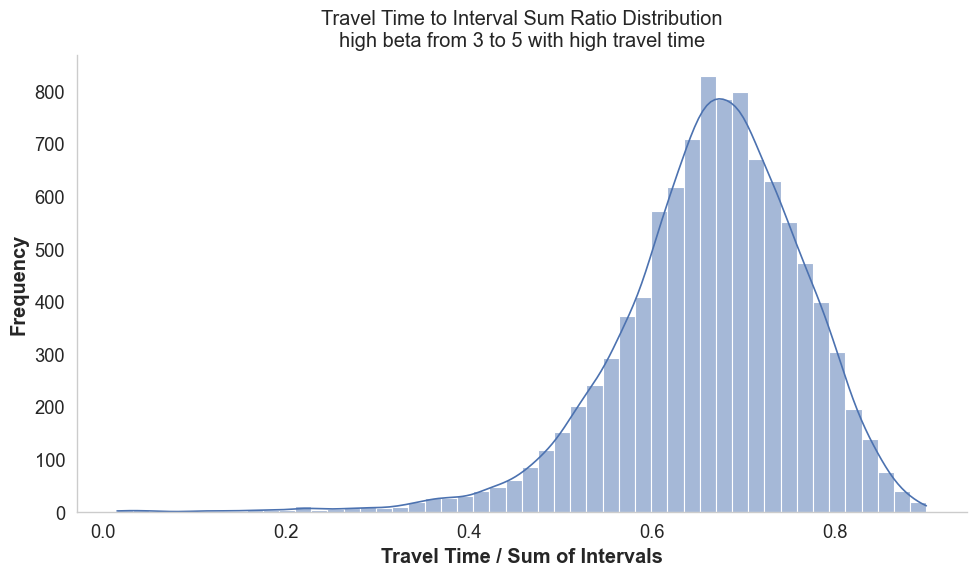

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/b0aab_10K.pkl



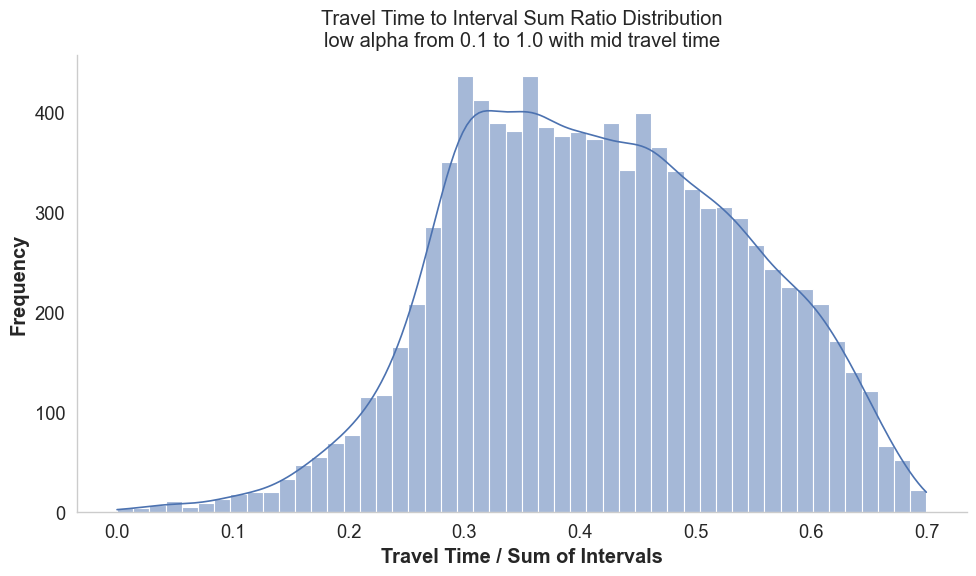

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/f4f29_10K.pkl



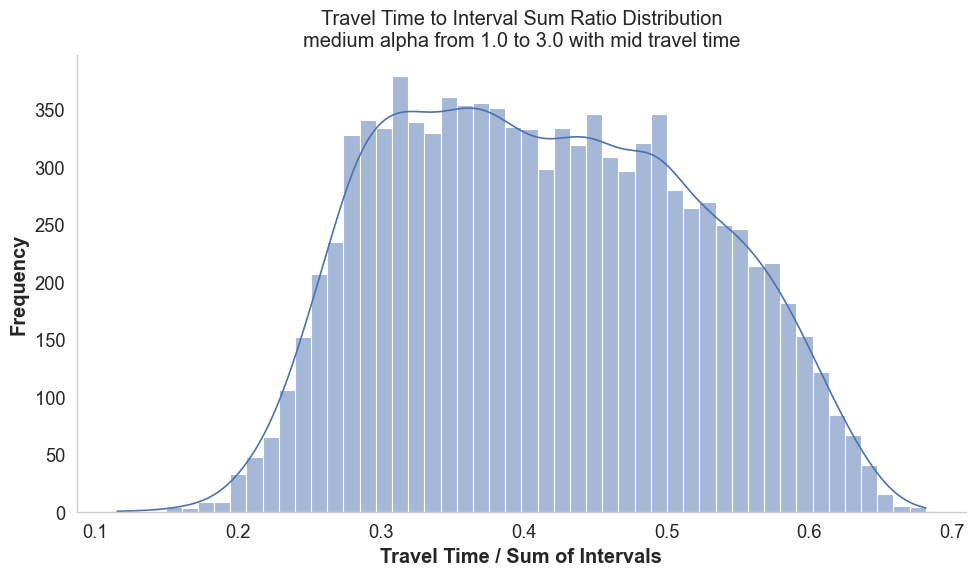

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/d2d33_10K.pkl



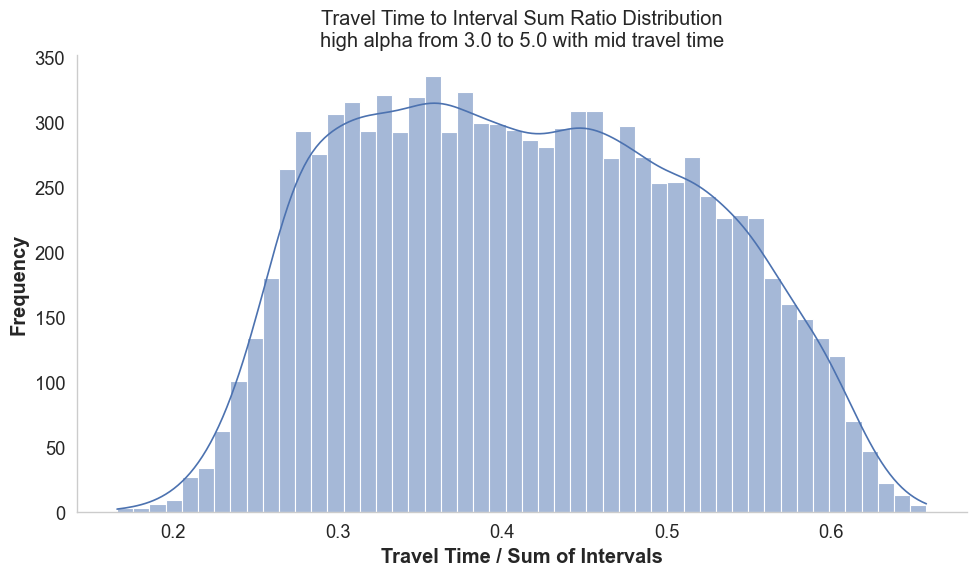

[INFO] Dataset already exists:
/Users/preetkaria/PycharmProjects/when_to_leave/data/9212e_10K.pkl



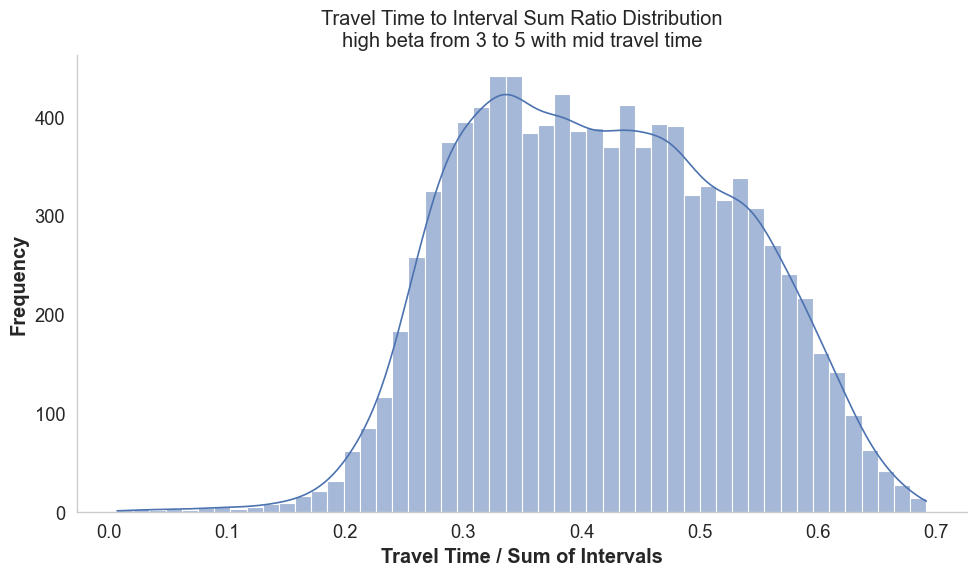

In [16]:
for test_name, config in sim_tests.items():
    
    test_df_path = generate_data.generate(config=config, row_count=10_000)
    test_df = pd.DataFrame()
    with open(test_df_path, 'rb') as f:
        test_df =pickle.load(f)
        
    travel_times = test_df['travel_time'].values
    interval_sum = list(map(sum, test_df['intervals']))
    
    zip_data = list(zip(travel_times, interval_sum))
    
    # ratio of travel time to interval sum
    ratios = [tt / isum if isum > 0 else 0 for tt, isum in zip_data]
    plt.figure(figsize=(10, 6))
    sns.histplot(ratios, bins=50, kde=True)
    plt.xlabel('Travel Time / Sum of Intervals')
    plt.ylabel('Frequency')
    plt.title(f'Travel Time to Interval Sum Ratio Distribution\n{test_name}')
    plt.grid()
    sns.despine()
    plt.tight_layout()
    plt.show()
    